In [1]:
video_frame = 4.2

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
from statistics import median

In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [4]:
import math
import time
from operator import itemgetter

previous_right_left_lanes = [(0,0),(0,0),(0,0),(0,0)]

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def clahe_auto_params(img):
    
    #set tileGridSize
    tileGridSize = (8,8)
    
    # median gray channel intensity
    x_center = img.shape[1]/2

    crop_y_t = 0.70*img.shape[0]
    crop_y_l = 0.83*img.shape[0]
    crop_x_r = x_center+0.28*img.shape[1]
    crop_x_l = x_center-0.28*img.shape[1]

    crop_img = img[crop_y_t:crop_y_l,crop_x_l:crop_x_r]
    
    if  crop_img.mean() > 150:  
        clipLimit = 3
    elif crop_img.mean() > 140:  
        clipLimit = 2
    elif crop_img.mean() > 90:
        clipLimit = 1    
    elif crop_img.mean() > 70:
        clipLimit = 0.12        
    else:
        clipLimit = 0.06  
        
    return (clipLimit, tileGridSize)    
    
    
    
    
def canny_auto_threshold(img,sigma=0.3):
    # median gray channel intensity
    x_center = img.shape[1]/2

    crop_y_t = 0.70*img.shape[0]
    crop_y_l = 0.83*img.shape[0]
    crop_x_r = x_center+0.28*img.shape[1]
    crop_x_l = x_center-0.28*img.shape[1]

    crop_img = img[crop_y_t:crop_y_l,crop_x_l:crop_x_r]
    
    
    # calculate low and high threshold
    high_threshold = min(255, crop_img.max())   
    low_threshold = high_threshold/2
    
    return (low_threshold, high_threshold)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    
    y_size = img.shape[0]
    x_size = img.shape[1]
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, previous_right_left_lanes,color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    #initialization
    
    #array initialization
    rt_lane_slopes = []
    lf_lane_slopes = []
    
    #var initialization
    rt_lines_pos = []
    lf_lines_pos = []
    
    for line in lines:
        for x1,y1,x2,y2 in line: 
            
            pi = np.pi
            m = ((y2-y1)/(x2-x1))
            m_angle = np.arctan(m)
            x_center = img.shape[1]/2
            
            #remove
            cv2.line(img, (x1, y1), (x2, y2), [0,0,255], thickness)
            
            rt_lw_x=previous_right_left_lanes[0][0]
            (rt_top_x,rt_top_y)=(previous_right_left_lanes[1][0],previous_right_left_lanes[1][1])
            lf_lw_x=previous_right_left_lanes[2][0]
            (lf_top_x,lf_top_y)=(previous_right_left_lanes[3][0],previous_right_left_lanes[3][1])
            
            if not ((rt_top_x-rt_lw_x) == 0):
                prev_r_slope = ((rt_top_y-img.shape[0])/(rt_top_x-rt_lw_x))
                r_lane_variation = abs(prev_r_slope-m)
            else:
                r_lane_variation = 0
                
            if not ((lf_top_x-lf_lw_x) == 0):
                prev_l_slope = ((lf_top_y-img.shape[0])/(lf_top_x-lf_lw_x))
                l_lane_variation = abs(prev_l_slope-m)
            else:
                l_lane_variation = 0
            
            #right lane
            if m > 0.55 and m < 0.75 and r_lane_variation < 0.1 and x1>(x_center+50):
                #append slope values
                rt_lane_slopes.append(m)
                #append line positions
                rt_lines_pos.append((x1,y1))
                #extra1: rt_lines_pos.append((int(math.floor((x1+x2)/2)),int(math.floor((y1+y2)/2))))
                
            elif m < -0.60 and m > -0.80 and l_lane_variation < 0.1 and x2<(x_center-50):
                #append slope values
                lf_lane_slopes.append(m)
                #append line positions
                lf_lines_pos.append((x2,y2)) 
                #extra1: lf_lines_pos.append((int(math.floor((x1+x2)/2)),int(math.floor((y1+y2)/2))))
                         
    
    #drawing right lane
    print("right lane slopes:", rt_lane_slopes)
    if not rt_lines_pos:
        cv2.line(img,previous_right_left_lanes[0],previous_right_left_lanes[1], color, thickness)
    
    else:
        #average slopes
        rt_slope_avg = median(rt_lane_slopes)
    
        #determine right lane position
        rt_lines_pos = sorted(rt_lines_pos, key=itemgetter(0))
        rt_lane_pos = rt_lines_pos[int(math.floor(len(rt_lines_pos)/2))]
        rt_top = rt_lines_pos[0]
    
        #set x/y position for right lane upper end
        rt_top_x = rt_top[0]
        rt_top_y = rt_top[1]
    
        rt_lw_y = img.shape[0]
    
        #calculate x position for right lane lower end
        print(rt_lw_y,rt_top_y,rt_slope_avg,rt_top_x)
        rt_lw_x = int(math.floor(((rt_lw_y - rt_top_y) / rt_slope_avg + rt_top_x)))
    
        cv2.line(img, (rt_lw_x, img.shape[0]), (rt_top_x, rt_top_y), color, thickness)
        previous_right_left_lanes[0] = (rt_lw_x, img.shape[0])
        previous_right_left_lanes[1] = (rt_top_x, rt_top_y)
    
    #-----------------
    
    #drawing left lane
    print("left lane slopes:", lf_lane_slopes) 
    if not lf_lines_pos:
        cv2.line(img,previous_right_left_lanes[2],previous_right_left_lanes[3], color, thickness)
        return  
    
    else:
        #average slopes
        lf_slope_avg = median(lf_lane_slopes)  

        #determine left lane position
        lf_lines_pos = sorted(lf_lines_pos, key=itemgetter(0))    
        lf_lane_pos = lf_lines_pos[int(math.floor(len(lf_lines_pos)/2))]
        lf_top = lf_lines_pos[int(len(lf_lines_pos)-1)]
    
        #set x/y position for left lane upper end
        lf_top_x = lf_top[0]
        lf_top_y = lf_top[1]
 
        lf_lw_y = img.shape[0]
    
        #calculate x position for left lane lower end
        lf_lw_x = int(math.floor((lf_lw_y - lf_top_y) / lf_slope_avg + lf_top_x))
    
        cv2.line(img, (lf_lw_x, img.shape[0]), (lf_top_x, lf_top_y), color, thickness)  
        previous_right_left_lanes[2] = (lf_lw_x, img.shape[0])
        previous_right_left_lanes[3] = (lf_top_x, lf_top_y)
        
        return previous_right_left_lanes

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,previous_right_left_lanes):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    previous_right_left_lanes = draw_lines(line_img, lines, previous_right_left_lanes)
    print(previous_right_left_lanes)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def CLAHE_img(img,clipLimit, tileGridSize):
    clahe = cv2.createCLAHE(clipLimit, tileGridSize)
    return clahe.apply(img)

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


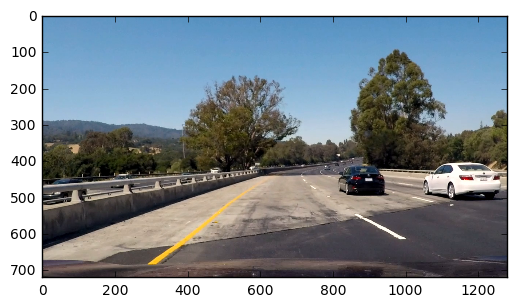

In [5]:
#reading in an image

#image = mpimg.imread('test_images/solidYellowCurve.jpg')
image = VideoFileClip('challenge.mp4').get_frame(video_frame)

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

(94, 717, 3)


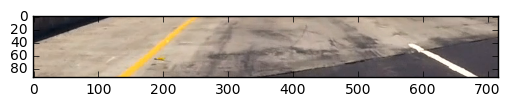

In [6]:
#test cell to remove
#plt.imshow(image)
x_center = image.shape[1]/2

crop_y_t = 560
crop_y_l = 660
crop_x_r = x_center+300
crop_x_l = x_center-300

#crop_y_t = 560
#crop_y_l = 660
#crop_x_r = x_center+500
#crop_x_l = x_center-500
x_center = image.shape[1]/2

crop_y_t = 0.70*image.shape[0]
crop_y_l = 0.83*image.shape[0]
crop_x_r = x_center+0.28*image.shape[1]
crop_x_l = x_center-0.28*image.shape[1]

crop_img = image[crop_y_t:crop_y_l,crop_x_l:crop_x_r]
plt.imshow(crop_img)
print(crop_img.shape)

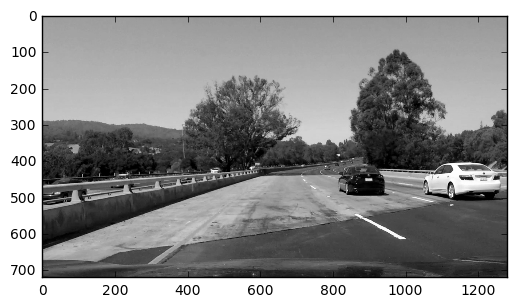

In [7]:
#reduce colored image to grayscaled image
image_grayed = grayscale(image)
plt.imshow(image_grayed, cmap='gray')

1
119.211673177


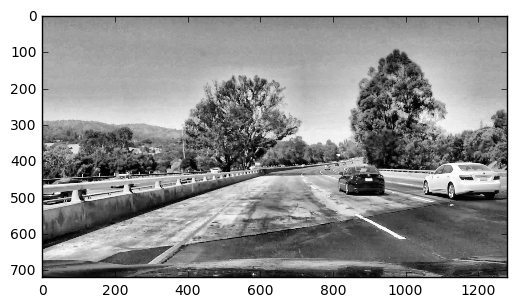

In [8]:
#apply CLAHE
clahe_params = clahe_auto_params(image_grayed)
#image_clahe = CLAHE_img(image_grayed,clahe_params[0],clahe_params[1])
image_clahe = CLAHE_img(image_grayed,3,clahe_params[1])
plt.imshow(image_clahe, cmap='gray')
print(clahe_params[0])
print(image_grayed.mean())

(127.5, 255)


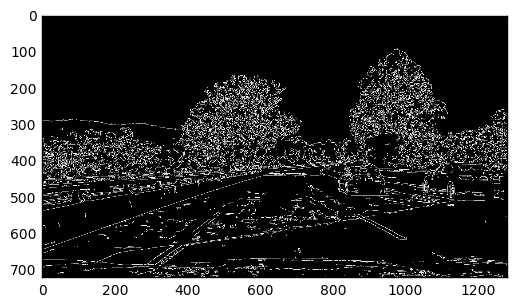

In [9]:
#apply canny to grayscaled image
canny_threshold = canny_auto_threshold(image_clahe)
image_canny = canny(image_clahe,canny_threshold[0],canny_threshold[1])
print(canny_threshold)
plt.imshow(image_canny, cmap='gray')

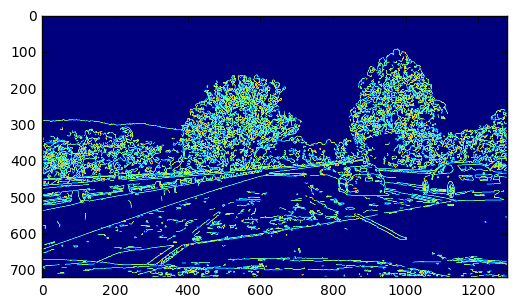

In [10]:
#apply gaussian blur to image
kernel_size = 3
image_gauss = gaussian_blur(image_canny,kernel_size)
plt.imshow(image_gauss)

[[[   0    0]
  [   0  720]
  [1280  720]
  [1280    0]]]


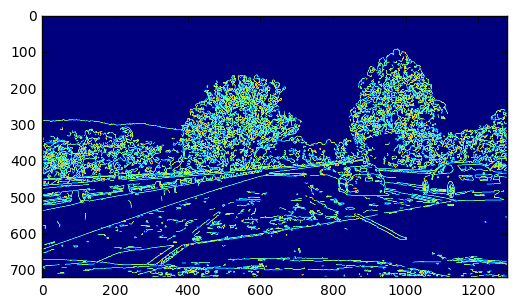

In [11]:
#pick area of interest

#x_center = image.shape[1] / 2
#top_left_v = (x_center-40,430)
#low_left_v = (200,image.shape[0]-60)
#top_right_v = (x_center+50,430)
#low_right_v = (image.shape[1] - 150,image.shape[0]-60)

if not (previous_right_left_lanes == [(0,0),(0,0),(0,0),(0,0)]):
    print("top",previous_right_left_lanes)
    roi_thres = 10
    #top_left_v = (max(0,previous_right_left_lanes[3][0]-roi_thres),max(0,previous_right_left_lanes[3][1]-roi_thres))
    #low_left_v = (max(0,previous_right_left_lanes[2][0]-roi_thres),min(image.shape[0],previous_right_left_lanes[2][1]+roi_thres))
    #top_right_v = (min(image.shape[1],previous_right_left_lanes[0][0]+roi_thres),max(0,previous_right_left_lanes[0][1]-roi_thres))
    #low_right_v = (min(image.shape[1],previous_right_left_lanes[1][0]+roi_thres),min(image.shape[0],previous_right_left_lanes[1][1]+roi_thres))
    top_left_v = (max(0,previous_right_left_lanes[1][0]-roi_thres),max(0,previous_right_left_lanes[1][1]-roi_thres))
    low_left_v = (max(0,previous_right_left_lanes[0][0]-roi_thres),min(image.shape[0],previous_right_left_lanes[0][1]+roi_thres))
    top_right_v = (min(image.shape[1],previous_right_left_lanes[3][0]+roi_thres),max(0,previous_right_left_lanes[3][1]-roi_thres))
    low_right_v = (min(image.shape[1],previous_right_left_lanes[2][0]+roi_thres),min(image.shape[0],previous_right_left_lanes[2][1]+roi_thres))


else:
    top_left_v = (0,0)
    low_left_v = (0,image.shape[0])
    top_right_v = (image.shape[1],0)
    low_right_v = (image.shape[1],image.shape[0])
    
vertices = np.array([[top_left_v,low_left_v,low_right_v,top_right_v]],dtype=np.int32)
print(vertices)
     
image_mask = region_of_interest(image_gauss,vertices)
plt.imshow(image_mask)

right lane slopes: [0.5625, 0.56521739130434778]
720 548 0.563858695652 868
left lane slopes: [-0.75, -0.73076923076923073, -0.69863013698630139, -0.72857142857142854, -0.77272727272727271, -0.66666666666666663, -0.63636363636363635, -0.70270270270270274, -0.70588235294117652]
[(1173, 720), (868, 548), (135, 720), (586, 402)]


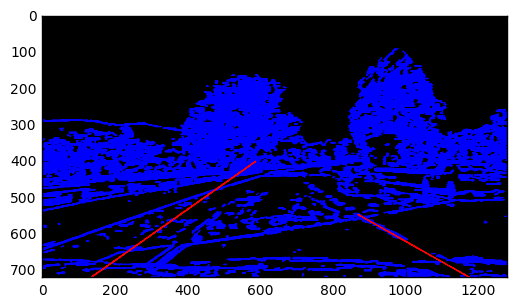

In [12]:
#determine hough lines
lines_hough = hough_lines(image_mask,0.5, np.pi/180, 40, 4, 4,previous_right_left_lanes)
vertices = np.array([[previous_right_left_lanes[3],previous_right_left_lanes[2],previous_right_left_lanes[0],previous_right_left_lanes[1]]],dtype=np.int32)  

plt.imshow(lines_hough)

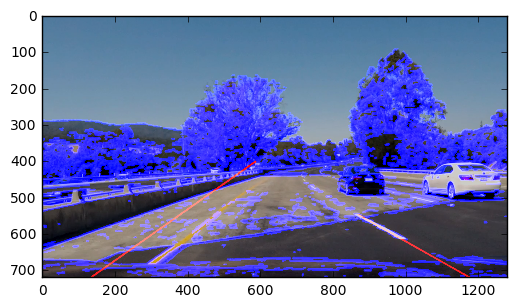

In [13]:
#Add weighed lines onto initial image
image_final = weighted_img(lines_hough,image)
plt.imshow(image_final)

In [47]:
def process_image(image):
    
    image_grayed = grayscale(image)
    clahe_params = clahe_auto_params(image_grayed)
    image_clahe = CLAHE_img(image_grayed,clahe_params[0],clahe_params[1])
    canny_threshold = canny_auto_threshold(image_clahe)
    image_canny = canny(image_clahe,canny_threshold[0],canny_threshold[1])
    kernel_size = 3
    image_gauss = gaussian_blur(image_canny,kernel_size)
    
    
    #x_center = image.shape[1] / 2
    #top_left_v = (x_center-40,430)
    #low_left_v = (200,image.shape[0]-60)
    #top_right_v = (x_center+50,430)
    #low_right_v = (image.shape[1] - 150,image.shape[0]-60)
    if previous_right_left_lanes != [(0,0),(0,0),(0,0),(0,0)]:
        roi_x_thres = 25
        roi_y_thres = 100
        top_left_v = (max(0,previous_right_left_lanes[3][0]-roi_x_thres),max(0,previous_right_left_lanes[3][1]-roi_y_thres))
        low_left_v = (max(0,previous_right_left_lanes[2][0]-roi_x_thres),min(image.shape[0],previous_right_left_lanes[2][1]+roi_y_thres))
        top_right_v = (min(image.shape[1],previous_right_left_lanes[0][0]+roi_x_thres),max(0,previous_right_left_lanes[0][1]-roi_y_thres))
        low_right_v = (min(image.shape[1],previous_right_left_lanes[1][0]+roi_x_thres),min(image.shape[0],previous_right_left_lanes[1][1]+roi_y_thres))
    else:
        top_left_v = (0,0)
        low_left_v = (0,image.shape[0])
        top_right_v = (image.shape[1],0)
        low_right_v = (image.shape[1],image.shape[0])
    
    vertices = np.array([[top_left_v,low_left_v,low_right_v,top_right_v]],dtype=np.int32)
    image_mask = region_of_interest(image_gauss,vertices)
    lines_hough = hough_lines(image_mask,0.5, np.pi/180, 40, 4, 4,previous_right_left_lanes)
    image_final = weighted_img(lines_hough,image)
    plt.imshow(image_final)
        
    return image_final

crop image mean: 102.949082203 chosen clip: 1
right lane slopes: []
left lane slopes: [-0.70588235294117652, -0.71900826446280997, -0.75221238938053092, -0.69491525423728817, -0.70329670329670335, -0.75221238938053092, -0.70338983050847459, -0.75409836065573765, -0.68421052631578949, -0.7142857142857143, -0.70129870129870131, -0.66666666666666663, -0.63157894736842102]
[(832, 540), (537, 338), (148, 540), (407, 358)]
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  0%|          | 0/222 [00:00<?, ?it/s]

crop image mean: 102.949082203 chosen clip: 1
right lane slopes: [0.60176991150442483, 0.62420382165605093]
540 337 0.61298686658 532
left lane slopes: [-0.72499999999999998, -0.77777777777777779, -0.78350515463917525, -0.72649572649572647, -0.75438596491228072, -0.72268907563025209, -0.78378378378378377, -0.73684210526315785, -0.7142857142857143, -0.72222222222222221, -0.7232142857142857, -0.72807017543859653, -0.72413793103448276, -0.77777777777777779, -0.7142857142857143, -0.75438596491228072, -0.73684210526315785, -0.77777777777777779, -0.75757575757575757]
[(863, 540), (532, 337), (157, 540), (407, 356)]
crop image mean: 101.986113328 chosen clip: 1


  1%|          | 2/222 [00:00<00:15, 13.94it/s]

right lane slopes: [0.62745098039215685, 0.60240963855421692]
540 342 0.614930309473 534
left lane slopes: [-0.75229357798165142, -0.72131147540983609, -0.78000000000000003, -0.72580645161290325, -0.77669902912621358, -0.72357723577235777, -0.72727272727272729, -0.72357723577235777, -0.76190476190476186, -0.72222222222222221, -0.77777777777777779, -0.69999999999999996, -0.76190476190476186]
[(855, 540), (534, 342), (160, 540), (405, 362)]
crop image mean: 101.767517957 chosen clip: 1
right lane slopes: [0.59748427672955973, 0.60169491525423724]
540 337 0.599589595992 532
left lane slopes: [-0.70833333333333337, -0.71999999999999997, -0.72222222222222221, -0.76190476190476186, -0.69999999999999996, -0.75294117647058822, -0.77272727272727271, -0.77272727272727271, -0.75324675324675328, -0.75, -0.72916666666666663, -0.75, -0.72619047619047616, -0.7142857142857143, -0.71014492753623193, -0.66666666666666663, -0.72413793103448276, -0.7142857142857143, -0.72972972972972971]
[(870, 540), (532

  2%|▏         | 4/222 [00:00<00:15, 14.07it/s]

crop image mean: 101.902420857 chosen clip: 1
right lane slopes: [0.58490566037735847, 0.58415841584158412, 0.5625, 0.57746478873239437, 0.55882352941176472]
540 341 0.577464788732 532
left lane slopes: [-0.71999999999999997, -0.69354838709677424, -0.75, -0.70370370370370372, -0.71999999999999997, -0.69696969696969702, -0.75, -0.76086956521739135, -0.75, -0.68253968253968256, -0.703125, -0.7142857142857143, -0.75, -0.75, -0.7441860465116279, -0.76744186046511631, -0.7857142857142857]
[(876, 540), (532, 341), (163, 540), (428, 343)]
crop image mean: 101.738308061 chosen clip: 1


  3%|▎         | 6/222 [00:00<00:14, 14.55it/s]

right lane slopes: [0.61988304093567248, 0.61904761904761907]
540 335 0.619465329992 536
left lane slopes: [-0.72413793103448276, -0.72727272727272729, -0.75]
[(866, 540), (536, 335), (156, 540), (390, 370)]
crop image mean: 101.871614791 chosen clip: 1
right lane slopes: [0.59842519685039375, 0.59999999999999998, 0.60264900662251653, 0.59999999999999998, 0.60150375939849621]
540 346 0.6 541
left lane slopes: [-0.6875, -0.65625, -0.69999999999999996, -0.66666666666666663, -0.66666666666666663]
[(864, 540), (541, 346), (137, 540), (385, 375)]
crop image mean: 101.997525938 chosen clip: 1
right lane slopes: [0.60479041916167664, 0.60655737704918034, 0.59999999999999998, 0.59999999999999998, 0.60439560439560436, 0.59999999999999998]
540 342 0.602197802198 535
left lane slopes: [-0.75, -0.71052631578947367, -0.70588235294117652, -0.72222222222222221, -0.71875, -0.66666666666666663]
[(863, 540), (535, 342), (155, 540), (378, 381)]
crop image mean: 102.220643788 chosen clip: 1
right lane slo

  5%|▍         | 10/222 [00:00<00:13, 15.67it/s]

crop image mean: 102.626682628 chosen clip: 1
right lane slopes: [0.60431654676258995, 0.60256410256410253, 0.67256637168141598]
540 343 0.604316546763 545
left lane slopes: [-0.67307692307692313, -0.66666666666666663, -0.66000000000000003, -0.76086956521739135, -0.7441860465116279, -0.7142857142857143, -0.75, -0.7142857142857143, -0.75, -0.69999999999999996, -0.75510204081632648, -0.68888888888888888]
[(870, 540), (545, 343), (153, 540), (421, 349)]
crop image mean: 103.150917797 chosen clip: 1
right lane slopes: [0.62790697674418605, 0.6262626262626263]
540 361 0.627084801503 561
left lane slopes: [-0.75, -0.72881355932203384, -0.7142857142857143, -0.65573770491803274, -0.72131147540983609, -0.78431372549019607, -0.77777777777777779, -0.66666666666666663, -0.72881355932203384]
[(846, 540), (561, 361), (159, 540), (417, 352)]
crop image mean: 103.132561852 chosen clip: 1
right lane slopes: [0.59999999999999998, 0.60402684563758391]
540 349 0.602013422819 545
left lane slopes: [-0.6470

  5%|▌         | 12/222 [00:00<00:13, 15.98it/s]

crop image mean: 101.69066241 chosen clip: 1
right lane slopes: [0.59999999999999998, 0.6271186440677966, 0.62352941176470589]
540 367 0.623529411765 566
left lane slopes: [-0.7024793388429752, -0.75, -0.67226890756302526, -0.67647058823529416, -0.75438596491228072, -0.75, -0.75221238938053092, -0.69999999999999996, -0.66666666666666663, -0.74545454545454548, -0.75454545454545452, -0.68852459016393441, -0.75609756097560976, -0.68421052631578949, -0.69999999999999996, -0.67647058823529416]
[(843, 540), (566, 367), (150, 540), (407, 360)]
crop image mean: 100.889358872 chosen clip: 1


  6%|▋         | 14/222 [00:00<00:13, 15.73it/s]

right lane slopes: [0.65116279069767447]
540 428 0.651162790698 660
left lane slopes: [-0.69465648854961837, -0.69999999999999996, -0.72033898305084743, -0.68181818181818177, -0.6875, -0.75, -0.73043478260869565, -0.69999999999999996, -0.70229007633587781, -0.72173913043478266, -0.71052631578947367, -0.72727272727272729, -0.74137931034482762, -0.70229007633587781, -0.75, -0.66666666666666663, -0.72727272727272729, -0.70422535211267601, -0.72807017543859653]
[(832, 540), (660, 428), (154, 540), (404, 363)]
crop image mean: 100.816812982 chosen clip: 1
right lane slopes: [0.6517857142857143, 0.65131578947368418]
540 391 0.65155075188 607
left lane slopes: [-0.69565217391304346, -0.72549019607843135, -0.69444444444444442, -0.75, -0.69724770642201839, -0.69724770642201839, -0.72999999999999998, -0.70192307692307687, -0.73913043478260865, -0.7142857142857143, -0.73913043478260865, -0.70114942528735635, -0.72727272727272729, -0.72727272727272729, -0.7441860465116279, -0.7009345794392523, -0.

  7%|▋         | 16/222 [00:01<00:13, 15.57it/s]

right lane slopes: [0.64903846153846156, 0.64921465968586389, 0.6495726495726496, 0.64341085271317833]
540 332 0.649126560612 532
left lane slopes: [-0.72307692307692306, -0.69863013698630139, -0.73134328358208955, -0.69863013698630139, -0.67123287671232879, -0.75, -0.77777777777777779, -0.75, -0.75, -0.70149253731343286, -0.71999999999999997, -0.75409836065573765, -0.75, -0.69230769230769229, -0.68000000000000005]
[(852, 540), (532, 332), (147, 540), (427, 338)]
crop image mean: 100.8858473 chosen clip: 1
right lane slopes: [0.60784313725490191, 0.62745098039215685, 0.62857142857142856]
540 371 0.627450980392 581
left lane slopes: [-0.66666666666666663, -0.63157894736842102, -0.66666666666666663, -0.75, -0.68965517241379315, -0.68000000000000005, -0.7142857142857143, -0.64000000000000001, -0.69230769230769229, -0.66666666666666663]
[(850, 540), (581, 371), (133, 540), (428, 342)]


  8%|▊         | 18/222 [00:01<00:13, 15.55it/s]

crop image mean: 101.11556265 chosen clip: 1
right lane slopes: [0.64772727272727271, 0.64429530201342278, 0.65600000000000003, 0.64516129032258063]
540 343 0.646444281525 550
left lane slopes: [-0.6875, -0.69696969696969702, -0.66666666666666663, -0.66666666666666663, -0.69696969696969702, -0.73333333333333328]
[(854, 540), (550, 343), (133, 540), (422, 340)]
crop image mean: 100.853365257 chosen clip: 1
right lane slopes: [0.62376237623762376, 0.64935064935064934]
540 379 0.636556512794 590
left lane slopes: [-0.69230769230769229, -0.67567567567567566, -0.68421052631578949, -0.69444444444444442, -0.72727272727272729, -0.63888888888888884, -0.67567567567567566, -0.69999999999999996]
[(842, 540), (590, 379), (147, 540), (379, 381)]


  9%|▉         | 20/222 [00:01<00:13, 15.21it/s]

crop image mean: 101.183825486 chosen clip: 1
right lane slopes: [0.62189054726368154, 0.62189054726368154, 0.64948453608247425, 0.64880952380952384]
540 336 0.635350035537 531
left lane slopes: [-0.66666666666666663, -0.66666666666666663, -0.71794871794871795, -0.73170731707317072, -0.69999999999999996, -0.67441860465116277, -0.74285714285714288, -0.73170731707317072, -0.69230769230769229, -0.66666666666666663]
[(852, 540), (531, 336), (142, 540), (420, 347)]
crop image mean: 101.517823889 chosen clip: 1


 10%|▉         | 22/222 [00:01<00:13, 15.09it/s]

right lane slopes: [0.62820512820512819, 0.625]
540 340 0.626602564103 533
left lane slopes: [-0.69387755102040816, -0.69999999999999996, -0.72916666666666663, -0.73333333333333328, -0.67391304347826086, -0.75, -0.7142857142857143, -0.72093023255813948, -0.69999999999999996]
[(852, 540), (533, 340), (153, 540), (419, 350)]
crop image mean: 101.947273211 chosen clip: 1
right lane slopes: [0.64900662251655628]
540 341 0.649006622517 533
left lane slopes: [-0.67796610169491522, -0.75471698113207553, -0.75471698113207553, -0.65573770491803274, -0.69230769230769229, -0.76923076923076927, -0.65384615384615385, -0.75, -0.71111111111111114]
[(839, 540), (533, 341), (156, 540), (418, 354)]


 11%|█         | 24/222 [00:01<00:12, 15.81it/s]

crop image mean: 102.173184358 chosen clip: 1
right lane slopes: [0.60784313725490191, 0.64102564102564108, 0.64864864864864868, 0.60683760683760679, 0.62758620689655176]
540 341 0.627586206897 539
left lane slopes: [-0.75, -0.72857142857142854, -0.75757575757575757, -0.65333333333333332, -0.75, -0.65277777777777779, -0.64864864864864868, -0.671875]
[(856, 540), (539, 341), (154, 540), (342, 409)]
crop image mean: 101.848151104 chosen clip: 1
right lane slopes: [0.66981132075471694, 0.6160714285714286, 0.61946902654867253, 0.67619047619047623, 0.61946902654867253, 0.6517857142857143, 0.62385321100917435, 0.65000000000000002, 0.6216216216216216, 0.67368421052631577]
540 368 0.636926605505 571
left lane slopes: [-0.71590909090909094, -0.72941176470588232, -0.6741573033707865, -0.67045454545454541, -0.67032967032967028, -0.74390243902439024, -0.68333333333333335, -0.67441860465116277, -0.67391304347826086, -0.72941176470588232, -0.72222222222222221, -0.72289156626506024]
[(841, 540), (571

 12%|█▏        | 26/222 [00:01<00:12, 15.55it/s]

right lane slopes: [0.624, 0.6470588235294118]
540 339 0.635529411765 532
left lane slopes: [-0.67142857142857137, -0.67375886524822692, -0.67307692307692313, -0.7567567567567568, -0.72268907563025209, -0.73043478260869565, -0.67479674796747968, -0.7558139534883721, -0.78947368421052633, -0.66666666666666663, -0.68181818181818177, -0.78260869565217395, -0.74358974358974361, -0.67142857142857137, -0.67241379310344829]
[(848, 540), (532, 339), (141, 540), (405, 360)]
crop image mean: 100.205347167 chosen clip: 1
right lane slopes: []
left lane slopes: [-0.76190476190476186, -0.69791666666666663, -0.7010309278350515, -0.74358974358974361, -0.66666666666666663, -0.72619047619047616, -0.68000000000000005, -0.73076923076923073, -0.67567567567567566, -0.77272727272727271, -0.76666666666666672, -0.67567567567567566]
[(848, 540), (532, 339), (148, 540), (397, 363)]
crop image mean: 100.353125831 chosen clip: 1


 13%|█▎        | 28/222 [00:01<00:12, 15.97it/s]

right lane slopes: [0.62666666666666671, 0.625, 0.6292134831460674]
540 345 0.626666666667 536
left lane slopes: [-0.66666666666666663, -0.75, -0.69841269841269837, -0.74468085106382975, -0.69696969696969702, -0.75, -0.67441860465116277, -0.75609756097560976, -0.75, -0.625, -0.69841269841269837, -0.75, -0.68000000000000005, -0.69841269841269837]
[(847, 540), (536, 345), (144, 540), (412, 353)]
crop image mean: 100.615456238 chosen clip: 1
right lane slopes: [0.60344827586206895, 0.60550458715596334, 0.62962962962962965]
540 373 0.605504587156 589
left lane slopes: [-0.63636363636363635, -0.70370370370370372, -0.70370370370370372]
[(864, 540), (589, 373), (150, 540), (391, 371)]


 14%|█▎        | 30/222 [00:01<00:11, 16.37it/s]

crop image mean: 100.897020484 chosen clip: 1
right lane slopes: [0.62658227848101267, 0.62721893491124259, 0.62732919254658381, 0.62727272727272732, 0.62820512820512819, 0.60227272727272729]
540 346 0.627245831092 538
left lane slopes: [-0.66666666666666663, -0.70967741935483875, -0.66666666666666663, -0.66666666666666663, -0.7142857142857143, -0.6875]
[(847, 540), (538, 346), (130, 540), (421, 343)]
crop image mean: 101.099122107 chosen clip: 1
right lane slopes: [0.64935064935064934, 0.625]
540 344 0.637175324675 536
left lane slopes: [-0.67567567567567566, -0.72222222222222221, -0.68421052631578949, -0.75757575757575757, -0.77419354838709675, -0.72222222222222221, -0.625, -0.63636363636363635, -0.70588235294117652]
[(843, 540), (536, 344), (145, 540), (423, 344)]


 14%|█▍        | 32/222 [00:02<00:11, 16.24it/s]

crop image mean: 101.390689013 chosen clip: 1
right lane slopes: [0.64963503649635035, 0.64900662251655628]
540 343 0.649320829506 540
left lane slopes: [-0.67441860465116277, -0.72499999999999998, -0.73170731707317072, -0.66666666666666663, -0.70270270270270274, -0.67647058823529416, -0.66666666666666663]
[(843, 540), (540, 343), (139, 540), (423, 348)]
crop image mean: 102.029981378 chosen clip: 1


 15%|█▌        | 34/222 [00:02<00:11, 16.54it/s]

right lane slopes: [0.64444444444444449, 0.69230769230769229, 0.65079365079365081]
540 346 0.650793650794 550
left lane slopes: [-0.69999999999999996, -0.69387755102040816, -0.70588235294117652, -0.76190476190476186, -0.7021276595744681, -0.76086956521739135, -0.6875, -0.6875, -0.69999999999999996]
[(848, 540), (550, 346), (148, 540), (364, 389)]
crop image mean: 102.606996542 chosen clip: 1
right lane slopes: [0.59748427672955973, 0.59876543209876543, 0.6470588235294118, 0.59999999999999998, 0.65079365079365081, 0.6462585034013606, 0.64341085271317833, 0.60416666666666663, 0.65000000000000002, 0.6454545454545455, 0.59999999999999998]
540 345 0.643410852713 538
left lane slopes: [-0.69491525423728817, -0.70175438596491224, -0.67272727272727273, -0.75471698113207553, -0.70175438596491224, -0.75510204081632648, -0.74545454545454548, -0.75, -0.76470588235294112, -0.68518518518518523]
[(841, 540), (538, 345), (159, 540), (354, 399)]
crop image mean: 102.797499335 chosen clip: 1
right lane 

 16%|█▌        | 36/222 [00:02<00:11, 16.74it/s]

crop image mean: 102.371934025 chosen clip: 1
right lane slopes: [0.64130434782608692, 0.65322580645161288, 0.65000000000000002, 0.64748201438848918]
540 360 0.648741007194 557
left lane slopes: [-0.75903614457831325, -0.6741573033707865, -0.67816091954022983, -0.66666666666666663, -0.78481012658227844, -0.67777777777777781, -0.68000000000000005, -0.77941176470588236, -0.7567567567567568, -0.78378378378378377, -0.69230769230769229]
[(834, 540), (557, 360), (147, 540), (413, 356)]


 17%|█▋        | 38/222 [00:02<00:10, 16.95it/s]

crop image mean: 101.821096036 chosen clip: 1
right lane slopes: [0.67241379310344829, 0.60360360360360366, 0.65151515151515149, 0.59999999999999998]
540 366 0.627559377559 566
left lane slopes: [-0.75229357798165142, -0.69230769230769229, -0.75471698113207553, -0.67826086956521736, -0.74757281553398058, -0.67256637168141598, -0.69811320754716977, -0.73076923076923073, -0.67543859649122806, -0.7570093457943925, -0.66666666666666663]
[(843, 540), (566, 366), (158, 540), (313, 432)]
crop image mean: 101.037323756 chosen clip: 1
right lane slopes: [0.62135922330097082, 0.61904761904761907, 0.59803921568627449, 0.59803921568627449, 0.59999999999999998, 0.62318840579710144, 0.62962962962962965, 0.59999999999999998]
540 390 0.609523809524 602
left lane slopes: [-0.67142857142857137, -0.73333333333333328, -0.75630252100840334, -0.67625899280575541, -0.67883211678832112, -0.75, -0.75, -0.66666666666666663, -0.75, -0.68131868131868134, -0.66666666666666663, -0.7142857142857143, -0.6724137931034

 19%|█▉        | 42/222 [00:02<00:10, 16.90it/s]

crop image mean: 101.02349029 chosen clip: 1
right lane slopes: [0.64948453608247425, 0.65161290322580645, 0.65384615384615385, 0.65000000000000002]
540 343 0.650806451613 536
left lane slopes: [-0.69230769230769229, -0.66666666666666663, -0.69999999999999996, -0.71999999999999997, -0.69230769230769229, -0.71999999999999997, -0.72727272727272729, -0.70370370370370372, -0.77777777777777779]
[(838, 540), (536, 343), (149, 540), (392, 369)]
crop image mean: 101.317903698 chosen clip: 1
right lane slopes: [0.65068493150684936, 0.65137614678899081, 0.65000000000000002, 0.625]
540 347 0.650342465753 542
left lane slopes: [-0.70967741935483875, -0.72413793103448276, -0.66666666666666663]
[(838, 540), (542, 347), (146, 540), (406, 356)]
crop image mean: 101.413939878 chosen clip: 1
right lane slopes: [0.63076923076923075, 0.66896551724137931]
540 347 0.649867374005 546
left lane slopes: [-0.77419354838709675, -0.74285714285714288, -0.75757575757575757, -0.72727272727272729, -0.6857142857142857

 21%|██        | 46/222 [00:02<00:10, 16.24it/s]

crop image mean: 101.840595903 chosen clip: 1
right lane slopes: [0.67441860465116277, 0.64864864864864868]
540 335 0.66153362665 537
left lane slopes: [-0.72916666666666663, -0.70833333333333337, -0.72340425531914898, -0.69230769230769229, -0.71739130434782605, -0.71739130434782605, -0.72413793103448276, -0.6875, -0.6875, -0.70270270270270274]
[(846, 540), (537, 335), (142, 540), (416, 345)]
crop image mean: 102.217956903 chosen clip: 1
right lane slopes: [0.65116279069767447, 0.65306122448979587, 0.64634146341463417, 0.65476190476190477]
540 353 0.652112007594 551
left lane slopes: [-0.7142857142857143, -0.7142857142857143, -0.7142857142857143, -0.72727272727272729, -0.72222222222222221]
[(837, 540), (551, 353), (145, 540), (386, 368)]
crop image mean: 102.489651503 chosen clip: 1
right lane slopes: [0.64848484848484844, 0.64912280701754388, 0.64800000000000002, 0.65753424657534243, 0.65000000000000002, 0.65476190476190477]
540 340 0.649561403509 532
left lane slopes: [-0.67605633802

 22%|██▏       | 48/222 [00:03<00:11, 15.79it/s]

right lane slopes: [0.6517857142857143, 0.65000000000000002, 0.65573770491803274]
540 367 0.651785714286 572
left lane slopes: [-0.75308641975308643, -0.7142857142857143, -0.69411764705882351, -0.69767441860465118, -0.68055555555555558, -0.74683544303797467, -0.75324675324675328, -0.75609756097560976, -0.70114942528735635, -0.72222222222222221, -0.75641025641025639, -0.7142857142857143, -0.69333333333333336]
[(837, 540), (572, 367), (143, 540), (408, 351)]
crop image mean: 101.498403831 chosen clip: 1
right lane slopes: [0.64444444444444449, 0.67708333333333337, 0.67500000000000004]
540 346 0.675 547
left lane slopes: [-0.65000000000000002, -0.7009345794392523, -0.7053571428571429, -0.78217821782178221, -0.78000000000000003, -0.75824175824175821, -0.7142857142857143, -0.77777777777777779, -0.75903614457831325, -0.70270270270270274, -0.68627450980392157, -0.76056338028169013, -0.70666666666666667, -0.78217821782178221, -0.69999999999999996, -0.78947368421052633]
[(834, 540), (547, 346),

 23%|██▎       | 50/222 [00:03<00:11, 15.57it/s]

crop image mean: 99.8386272945 chosen clip: 1
right lane slopes: [0.6517857142857143]
540 367 0.651785714286 571
left lane slopes: [-0.73684210526315785, -0.65217391304347827, -0.69724770642201839, -0.75268817204301075, -0.69999999999999996, -0.7142857142857143, -0.6964285714285714, -0.69999999999999996, -0.77647058823529413, -0.73913043478260865, -0.77777777777777779, -0.77215189873417722, -0.74736842105263157, -0.77777777777777779, -0.69724770642201839]
[(836, 540), (571, 367), (150, 540), (426, 337)]


 23%|██▎       | 52/222 [00:03<00:11, 15.19it/s]

crop image mean: 99.8537110934 chosen clip: 1
right lane slopes: [0.64739884393063585, 0.64772727272727271, 0.65000000000000002]
540 337 0.647727272727 539
left lane slopes: [-0.67441860465116277, -0.75409836065573765, -0.66666666666666663, -0.75, -0.67469879518072284, -0.75362318840579712, -0.67441860465116277, -0.69047619047619047, -0.75, -0.66666666666666663, -0.75714285714285712, -0.68181818181818177, -0.75, -0.67469879518072284, -0.77272727272727271]
[(852, 540), (539, 337), (134, 540), (410, 350)]
crop image mean: 100.066560255 chosen clip: 1
right lane slopes: [0.65034965034965031, 0.6028368794326241, 0.60377358490566035, 0.67289719626168221, 0.67021276595744683]
540 344 0.65034965035 540
left lane slopes: [-0.66666666666666663, -0.68965517241379315, -0.7142857142857143, -0.75, -0.6785714285714286, -0.65517241379310343, -0.63636363636363635, -0.625, -0.65384615384615385, -0.69230769230769229, -0.69565217391304346, -0.75, -0.7142857142857143]
[(841, 540), (540, 344), (130, 540), 

 25%|██▌       | 56/222 [00:03<00:11, 14.83it/s]

crop image mean: 100.123862729 chosen clip: 1
right lane slopes: [0.65277777777777779, 0.63157894736842102, 0.60122699386503065, 0.62809917355371903]
540 347 0.629839060461 542
left lane slopes: [-0.66666666666666663, -0.67567567567567566, -0.65714285714285714, -0.66666666666666663, -0.65714285714285714]
[(848, 540), (542, 347), (121, 540), (417, 343)]
crop image mean: 100.466347433 chosen clip: 1
right lane slopes: [0.65420560747663548]
540 374 0.654205607477 580
left lane slopes: [-0.69767441860465118, -0.66666666666666663, -0.61904761904761907, -0.73170731707317072, -0.69230769230769229, -0.72222222222222221, -0.74358974358974361, -0.66666666666666663, -0.68292682926829273, -0.63636363636363635, -0.65789473684210531, -0.69230769230769229]
[(833, 540), (580, 374), (139, 540), (420, 347)]
crop image mean: 100.926815642 chosen clip: 1
right lane slopes: [0.64885496183206104, 0.62608695652173918, 0.65217391304347827]
540 375 0.648854961832 580
left lane slopes: [-0.66000000000000003, -0

 26%|██▌       | 58/222 [00:03<00:11, 14.74it/s]

crop image mean: 101.36217079 chosen clip: 1
right lane slopes: [0.6705882352941176, 0.62416107382550334]
540 346 0.64737465456 542
left lane slopes: [-0.67500000000000004, -0.6964285714285714, -0.67241379310344829, -0.67796610169491522, -0.73684210526315785, -0.70370370370370372, -0.65573770491803274, -0.6875, -0.68000000000000005, -0.66666666666666663]
[(841, 540), (542, 346), (134, 540), (414, 350)]
crop image mean: 101.602819899 chosen clip: 1
right lane slopes: [0.62903225806451613, 0.6097560975609756, 0.59999999999999998, 0.625, 0.62790697674418605, 0.62637362637362637]
540 348 0.625686813187 537
left lane slopes: [-0.65151515151515149, -0.72727272727272729, -0.72463768115942029, -0.75, -0.6619718309859155, -0.66666666666666663, -0.73015873015873012, -0.6470588235294118, -0.72857142857142854, -0.6875, -0.66666666666666663]
[(843, 540), (537, 348), (138, 540), (412, 352)]
crop image mean: 101.249507848 chosen clip: 1
right lane slopes: [0.65254237288135597, 0.63235294117647056]
54

 28%|██▊       | 62/222 [00:03<00:11, 14.52it/s]

crop image mean: 100.977573823 chosen clip: 1
right lane slopes: [0.62650602409638556, 0.65517241379310343]
540 400 0.640839218945 615
left lane slopes: [-0.64406779661016944, -0.70588235294117652, -0.72727272727272729, -0.75, -0.65454545454545454, -0.72972972972972971, -0.72477064220183485, -0.63157894736842102, -0.66666666666666663, -0.64935064935064934, -0.74468085106382975, -0.6495726495726496, -0.625, -0.70588235294117652, -0.67647058823529416, -0.75, -0.7142857142857143]
[(833, 540), (615, 400), (142, 540), (416, 347)]
crop image mean: 100.242245278 chosen clip: 1
right lane slopes: [0.66666666666666663, 0.64516129032258063, 0.64800000000000002, 0.64921465968586389]
540 336 0.648607329843 531
left lane slopes: [-0.63636363636363635, -0.65217391304347827, -0.6992481203007519, -0.64383561643835618, -0.69999999999999996, -0.64761904761904765, -0.70078740157480313, -0.65217391304347827, -0.703125, -0.703125, -0.65034965034965031, -0.69999999999999996, -0.65000000000000002, -0.6534653

 30%|██▉       | 66/222 [00:04<00:10, 14.77it/s]

right lane slopes: [0.65000000000000002, 0.62650602409638556]
540 342 0.638253012048 532
left lane slopes: [-0.6470588235294118, -0.70833333333333337, -0.67500000000000004, -0.67105263157894735, -0.72916666666666663, -0.72727272727272729, -0.72549019607843135, -0.70833333333333337, -0.67164179104477617, -0.75, -0.65573770491803274, -0.68000000000000005, -0.72340425531914898, -0.676056338028169]
[(842, 540), (532, 342), (142, 540), (392, 367)]
crop image mean: 100.391487098 chosen clip: 1
right lane slopes: [0.67123287671232879, 0.62411347517730498, 0.625]
540 343 0.625 534
left lane slopes: [-0.66666666666666663, -0.63636363636363635, -0.66666666666666663, -0.65000000000000002, -0.66666666666666663, -0.69230769230769229]
[(849, 540), (534, 343), (130, 540), (406, 356)]
crop image mean: 100.619739292 chosen clip: 1
right lane slopes: [0.61016949152542377, 0.62650602409638556, 0.67326732673267331]
540 351 0.626506024096 542
left lane slopes: [-0.63636363636363635, -0.61538461538461542, -

 31%|███       | 68/222 [00:04<00:10, 14.64it/s]

crop image mean: 100.643974461 chosen clip: 1
right lane slopes: [0.64835164835164838, 0.6741573033707865]
540 381 0.661254475861 587
left lane slopes: [-0.69999999999999996, -0.6428571428571429, -0.67500000000000004, -0.70731707317073167, -0.6428571428571429, -0.66666666666666663, -0.65789473684210531, -0.72499999999999998]
[(827, 540), (587, 381), (132, 540), (419, 348)]
crop image mean: 100.827374302 chosen clip: 1
right lane slopes: [0.64864864864864868]
540 342 0.648648648649 541
left lane slopes: [-0.66666666666666663, -0.66666666666666663, -0.69387755102040816, -0.66666666666666663, -0.67346938775510201, -0.68888888888888888, -0.69565217391304346, -0.66666666666666663, -0.68181818181818177, -0.69767441860465118, -0.66666666666666663, -0.69230769230769229]
[(846, 540), (541, 342), (134, 540), (390, 367)]


 32%|███▏      | 70/222 [00:04<00:10, 14.69it/s]

crop image mean: 101.210827348 chosen clip: 1
right lane slopes: [0.6717557251908397, 0.671875]
540 353 0.671815362595 544
left lane slopes: [-0.66666666666666663, -0.67241379310344829, -0.67241379310344829, -0.66666666666666663, -0.69387755102040816, -0.67272727272727273, -0.69230769230769229, -0.65573770491803274, -0.71153846153846156, -0.6428571428571429, -0.660377358490566]
[(822, 540), (544, 353), (126, 540), (411, 349)]


 32%|███▏      | 72/222 [00:04<00:10, 14.74it/s]

crop image mean: 101.606491088 chosen clip: 1
right lane slopes: [0.64583333333333337]
540 385 0.645833333333 608
left lane slopes: [-0.65277777777777779, -0.61971830985915488, -0.70149253731343286, -0.71014492753623193, -0.65217391304347827, -0.73333333333333328, -0.72580645161290325, -0.625, -0.64864864864864868]
[(848, 540), (608, 385), (118, 540), (408, 351)]
crop image mean: 101.299467944 chosen clip: 1
right lane slopes: [0.65030674846625769, 0.65384615384615385, 0.625]
540 362 0.650306748466 558
left lane slopes: [-0.66666666666666663, -0.64772727272727271, -0.6987951807228916, -0.64444444444444449, -0.70238095238095233, -0.6470588235294118, -0.66666666666666663, -0.70588235294117652, -0.64835164835164838, -0.69135802469135799, -0.6470588235294118]
[(831, 540), (558, 362), (123, 540), (405, 352)]
crop image mean: 100.773689811 chosen clip: 1
right lane slopes: [0.6064516129032258, 0.69784172661870503, 0.61290322580645162, 0.62790697674418605, 0.60273972602739723]
540 344 0.61290

 33%|███▎      | 74/222 [00:04<00:10, 14.48it/s]

crop image mean: 100.14612929 chosen clip: 1
right lane slopes: [0.65217391304347827, 0.64893617021276595]
540 367 0.650555041628 564
left lane slopes: [-0.66666666666666663, -0.64864864864864868, -0.6470588235294118, -0.6962962962962963, -0.64935064935064934, -0.67692307692307696, -0.71999999999999997, -0.625, -0.65116279069767447, -0.64900662251655628, -0.7142857142857143, -0.68253968253968256, -0.69090909090909092, -0.65100671140939592, -0.68421052631578949]
[(829, 540), (564, 367), (128, 540), (400, 359)]
crop image mean: 99.7444001064 chosen clip: 1
right lane slopes: [0.65116279069767447, 0.65346534653465349, 0.63793103448275867]
540 351 0.651162790698 543
left lane slopes: [-0.64227642276422769, -0.64516129032258063, -0.64516129032258063, -0.6767676767676768, -0.64754098360655743, -0.70476190476190481, -0.69523809523809521, -0.69512195121951215, -0.69387755102040816, -0.63636363636363635, -0.69444444444444442, -0.63636363636363635]
[(833, 540), (543, 351), (129, 540), (395, 364)

 35%|███▌      | 78/222 [00:05<00:09, 14.52it/s]

crop image mean: 100.178105879 chosen clip: 1
right lane slopes: [0.62352941176470589, 0.67080745341614911, 0.67808219178082196, 0.67816091954022983, 0.67460317460317465]
540 345 0.674603174603 534
left lane slopes: [-0.65517241379310343, -0.66666666666666663, -0.7142857142857143, -0.67741935483870963, -0.64000000000000001, -0.6097560975609756, -0.625, -0.68965517241379315, -0.64102564102564108, -0.62068965517241381, -0.75]
[(823, 540), (534, 345), (123, 540), (423, 344)]
crop image mean: 100.490529396 chosen clip: 1
right lane slopes: [0.66981132075471694]
540 372 0.669811320755 586
left lane slopes: [-0.62857142857142856, -0.66666666666666663, -0.69999999999999996, -0.70967741935483875, -0.75, -0.69999999999999996]
[(836, 540), (586, 372), (142, 540), (422, 344)]
crop image mean: 100.717025805 chosen clip: 1
right lane slopes: [0.65277777777777779, 0.67625899280575541]
540 366 0.664518385292 561
left lane slopes: [-0.66666666666666663, -0.64864864864864868, -0.70588235294117652, -0.6

 37%|███▋      | 82/222 [00:05<00:09, 14.95it/s]

right lane slopes: [0.67307692307692313, 0.67391304347826086]
540 350 0.673494983278 538
left lane slopes: [-0.65909090909090906, -0.66666666666666663, -0.6428571428571429, -0.69444444444444442, -0.67500000000000004, -0.66666666666666663, -0.67441860465116277, -0.6097560975609756, -0.67500000000000004]
[(820, 540), (538, 350), (129, 540), (365, 383)]
crop image mean: 101.339797819 chosen clip: 1
right lane slopes: [0.64743589743589747, 0.64968152866242035, 0.67625899280575541, 0.64516129032258063, 0.64779874213836475, 0.65079365079365081, 0.67708333333333337]
540 342 0.649681528662 531
left lane slopes: [-0.61224489795918369, -0.63461538461538458, -0.71739130434782605, -0.61538461538461542, -0.68888888888888888, -0.71111111111111114, -0.68181818181818177, -0.66666666666666663, -0.66666666666666663]
[(835, 540), (531, 342), (127, 540), (414, 349)]
crop image mean: 102.096834264 chosen clip: 1
right lane slopes: [0.67567567567567566, 0.65217391304347827, 0.67532467532467533]
540 348 0.67

 38%|███▊      | 84/222 [00:05<00:09, 14.96it/s]

crop image mean: 102.145836659 chosen clip: 1
right lane slopes: [0.66666666666666663]
540 387 0.666666666667 607
left lane slopes: [-0.61904761904761907, -0.625, -0.67441860465116277, -0.66666666666666663, -0.63953488372093026, -0.64367816091954022, -0.62365591397849462, -0.67469879518072284, -0.62365591397849462, -0.67816091954022983, -0.6428571428571429, -0.64814814814814814]
[(836, 540), (607, 387), (109, 540), (428, 335)]
crop image mean: 101.676749135 chosen clip: 1
right lane slopes: [0.67759562841530052, 0.67441860465116277, 0.67682926829268297, 0.6785714285714286]
540 346 0.677212448354 533
left lane slopes: [-0.64912280701754388, -0.66666666666666663, -0.63, -0.67256637168141598, -0.61904761904761907, -0.69607843137254899, -0.63157894736842102, -0.66666666666666663, -0.69767441860465118, -0.62337662337662336, -0.6470588235294118, -0.62857142857142856, -0.62637362637362637, -0.62068965517241381]
[(819, 540), (533, 346), (116, 540), (401, 358)]
crop image mean: 100.986193136 ch

 39%|███▊      | 86/222 [00:05<00:09, 14.84it/s]

right lane slopes: [0.67910447761194026, 0.67567567567567566, 0.65000000000000002, 0.67105263157894735]
540 344 0.673364153627 533
left lane slopes: [-0.61111111111111116, -0.68181818181818177, -0.62337662337662336, -0.62179487179487181, -0.6742424242424242, -0.67692307692307696, -0.62318840579710144, -0.69999999999999996, -0.6692913385826772, -0.60869565217391308, -0.6742424242424242, -0.63157894736842102, -0.62903225806451613, -0.63793103448275867]
[(824, 540), (533, 344), (116, 540), (398, 361)]


 40%|███▉      | 88/222 [00:05<00:09, 14.69it/s]

crop image mean: 100.423463687 chosen clip: 1
right lane slopes: [0.69999999999999996, 0.67391304347826086, 0.70175438596491224]
540 344 0.7 531
left lane slopes: [-0.624, -0.69565217391304346, -0.624, -0.61904761904761907, -0.69999999999999996, -0.69607843137254899, -0.62135922330097082, -0.70129870129870131, -0.66666666666666663, -0.69565217391304346, -0.65217391304347827]
[(811, 540), (531, 344), (125, 540), (394, 361)]
crop image mean: 100.487416866 chosen clip: 1
right lane slopes: [0.67938931297709926, 0.67543859649122806, 0.67105263157894735]
540 353 0.675438596491 543
left lane slopes: [-0.66666666666666663, -0.62222222222222223, -0.61855670103092786, -0.625, -0.6428571428571429, -0.67164179104477617, -0.61458333333333337, -0.68421052631578949, -0.67123287671232879, -0.6811594202898551, -0.625, -0.7142857142857143, -0.66666666666666663, -0.68181818181818177]
[(819, 540), (543, 353), (123, 540), (423, 340)]
crop image mean: 100.353923916 chosen clip: 1
right lane slopes: [0.7230

 41%|████      | 90/222 [00:05<00:09, 14.29it/s]

crop image mean: 100.361292897 chosen clip: 1
right lane slopes: [0.70068027210884354, 0.70491803278688525, 0.69696969696969702, 0.69798657718120805, 0.66666666666666663, 0.70175438596491224, 0.70652173913043481]
540 344 0.700680272109 532
left lane slopes: [-0.63636363636363635, -0.625, -0.66666666666666663, -0.64516129032258063, -0.62857142857142856, -0.66666666666666663]
[(811, 540), (532, 344), (123, 540), (379, 376)]
crop image mean: 100.604841713 chosen clip: 1
right lane slopes: [0.70078740157480313, 0.6992481203007519, 0.7010309278350515, 0.69565217391304346]
540 349 0.700017760938 539
left lane slopes: [-0.68571428571428572, -0.64102564102564108, -0.65714285714285714, -0.66666666666666663, -0.63157894736842102]
[(811, 540), (539, 349), (119, 540), (416, 345)]
crop image mean: 100.497978186 chosen clip: 1
right lane slopes: [0.70138888888888884, 0.69999999999999996, 0.70329670329670335]
540 344 0.701388888889 532
left lane slopes: [-0.66666666666666663, -0.67441860465116277, -0

 42%|████▏     | 94/222 [00:06<00:08, 14.90it/s]

crop image mean: 100.723809524 chosen clip: 1
right lane slopes: [0.67153284671532842, 0.6690647482014388, 0.69852941176470584, 0.66911764705882348, 0.7007299270072993, 0.69999999999999996, 0.67391304347826086, 0.70149253731343286]
540 346 0.686221227621 535
left lane slopes: [-0.73333333333333328, -0.66666666666666663, -0.64583333333333337, -0.65217391304347827, -0.62264150943396224, -0.63636363636363635, -0.68085106382978722, -0.65957446808510634, -0.7142857142857143, -0.65306122448979587, -0.69999999999999996, -0.66000000000000003, -0.66666666666666663]
[(817, 540), (535, 346), (125, 540), (416, 348)]
crop image mean: 100.738414472 chosen clip: 1
right lane slopes: [0.65161290322580645, 0.65753424657534243, 0.70707070707070707, 0.67543859649122806, 0.65625]
540 342 0.657534246575 531
left lane slopes: [-0.61016949152542377, -0.66666666666666663, -0.62295081967213117, -0.64814814814814814, -0.66666666666666663, -0.63934426229508201, -0.6785714285714286, -0.63461538461538458]
[(832, 5

 44%|████▍     | 98/222 [00:06<00:08, 15.27it/s]

right lane slopes: [0.72435897435897434, 0.72058823529411764, 0.72727272727272729, 0.67647058823529416, 0.72268907563025209]
540 338 0.72268907563 531
left lane slopes: [-0.68421052631578949, -0.64772727272727271, -0.68421052631578949, -0.651685393258427, -0.62790697674418605, -0.67469879518072284, -0.69736842105263153, -0.7142857142857143, -0.67500000000000004, -0.69411764705882351, -0.66666666666666663, -0.73333333333333328, -0.68421052631578949, -0.69999999999999996]
[(810, 540), (531, 338), (136, 540), (410, 353)]
crop image mean: 100.238387869 chosen clip: 1
right lane slopes: [0.68103448275862066, 0.65789473684210531, 0.67391304347826086]
540 353 0.673913043478 549
left lane slopes: [-0.66972477064220182, -0.65000000000000002, -0.61739130434782608, -0.61946902654867253, -0.66666666666666663, -0.68354430379746833, -0.67741935483870963, -0.66981132075471694, -0.64583333333333337, -0.63013698630136983, -0.67289719626168221, -0.625]
[(826, 540), (549, 353), (122, 540), (405, 354)]
cr

 46%|████▌     | 102/222 [00:06<00:07, 15.42it/s]

crop image mean: 98.1630486832 chosen clip: 1
right lane slopes: [0.7192982456140351, 0.69841269841269837, 0.69230769230769229]
540 355 0.698412698413 567
left lane slopes: [-0.66666666666666663, -0.7142857142857143, -0.66666666666666663, -0.62962962962962965, -0.66666666666666663, -0.62244897959183676, -0.67088607594936711, -0.69841269841269837, -0.64583333333333337, -0.69444444444444442, -0.62, -0.62337662337662336, -0.62244897959183676, -0.60869565217391308]
[(831, 540), (567, 355), (116, 540), (427, 336)]
crop image mean: 98.4911146582 chosen clip: 1
right lane slopes: [0.70068027210884354, 0.70338983050847459, 0.70161290322580649]
540 346 0.701612903226 542
left lane slopes: [-0.625, -0.61224489795918369, -0.61702127659574468, -0.66666666666666663, -0.61702127659574468, -0.75, -0.66666666666666663, -0.67647058823529416, -0.66666666666666663, -0.6785714285714286, -0.64516129032258063, -0.61290322580645162, -0.66666666666666663, -0.66666666666666663]
[(818, 540), (542, 346), (129, 5

 47%|████▋     | 104/222 [00:06<00:07, 15.12it/s]

right lane slopes: [0.70642201834862384, 0.67532467532467533]
540 340 0.690873346837 535
left lane slopes: [-0.66666666666666663, -0.61538461538461542, -0.625, -0.67567567567567566, -0.61764705882352944, -0.60526315789473684]
[(824, 540), (535, 340), (114, 540), (424, 348)]
crop image mean: 99.6047885076 chosen clip: 1
right lane slopes: [0.70338983050847459, 0.70129870129870131, 0.69718309859154926]
540 341 0.701298701299 535
left lane slopes: [-0.65909090909090906, -0.61538461538461542, -0.68421052631578949, -0.61538461538461542, -0.63636363636363635, -0.66666666666666663, -0.66666666666666663]
[(818, 540), (535, 341), (133, 540), (423, 349)]
crop image mean: 100.048736366 chosen clip: 1
right lane slopes: [0.70085470085470081, 0.66666666666666663, 0.70512820512820518]
540 359 0.700854700855 558
left lane slopes: [-0.66666666666666663, -0.65306122448979587, -0.62745098039215685, -0.7142857142857143, -0.7142857142857143, -0.68000000000000005, -0.64444444444444449, -0.75, -0.6458333333

 49%|████▊     | 108/222 [00:07<00:07, 15.05it/s]

crop image mean: 101.291194467 chosen clip: 1
right lane slopes: [0.67567567567567566, 0.63636363636363635, 0.67910447761194026, 0.68235294117647061, 0.65789473684210531]
540 347 0.675675675676 543
left lane slopes: [-0.65277777777777779, -0.6376811594202898, -0.72727272727272729, -0.72131147540983609, -0.64000000000000001, -0.66666666666666663, -0.7142857142857143, -0.6428571428571429, -0.70588235294117652, -0.75]
[(828, 540), (543, 347), (138, 540), (415, 350)]
crop image mean: 101.214684757 chosen clip: 1
right lane slopes: [0.67938931297709926, 0.67619047619047623, 0.67441860465116277]
540 355 0.67619047619 555
left lane slopes: [-0.64772727272727271, -0.72499999999999998, -0.72151898734177211, -0.65116279069767447, -0.63157894736842102, -0.651685393258427, -0.72499999999999998, -0.70422535211267601, -0.6607142857142857, -0.63492063492063489, -0.66666666666666663]
[(828, 540), (555, 355), (125, 540), (412, 351)]
crop image mean: 100.76839585 chosen clip: 1
right lane slopes: [0.700

 50%|█████     | 112/222 [00:07<00:07, 14.69it/s]

right lane slopes: [0.65555555555555556, 0.67289719626168221, 0.67164179104477617]
540 379 0.671641791045 588
left lane slopes: [-0.71875, -0.65000000000000002, -0.64864864864864868, -0.7142857142857143, -0.65100671140939592, -0.75, -0.72519083969465647, -0.75, -0.65346534653465349, -0.72499999999999998, -0.64893617021276595, -0.72519083969465647, -0.72807017543859653, -0.65068493150684936, -0.72289156626506024, -0.66666666666666663, -0.75, -0.71052631578947367, -0.65034965034965031]
[(827, 540), (588, 379), (148, 540), (405, 357)]
crop image mean: 100.374381484 chosen clip: 1
right lane slopes: [0.65432098765432101, 0.67455621301775148, 0.72027972027972031, 0.6333333333333333, 0.70198675496688745, 0.65957446808510634, 0.72222222222222221, 0.70297029702970293, 0.67619047619047623, 0.67213114754098358]
540 340 0.675373344604 540
left lane slopes: [-0.68181818181818177, -0.64566929133858264, -0.65000000000000002, -0.625, -0.75268817204301075, -0.6484375, -0.64393939393939392, -0.66666666

 51%|█████▏    | 114/222 [00:07<00:07, 14.61it/s]

right lane slopes: [0.67132867132867136, 0.6767676767676768, 0.69230769230769229]
540 340 0.676767676768 544
left lane slopes: [-0.66666666666666663, -0.6470588235294118, -0.75, -0.65517241379310343, -0.6428571428571429, -0.66666666666666663, -0.7142857142857143, -0.61538461538461542, -0.63636363636363635, -0.65517241379310343]
[(839, 540), (544, 340), (125, 540), (411, 353)]
crop image mean: 100.936844906 chosen clip: 1
right lane slopes: [0.625, 0.67105263157894735, 0.67796610169491522]
540 338 0.671052631579 531
left lane slopes: [-0.69696969696969702, -0.625, -0.625, -0.6785714285714286, -0.70967741935483875]
[(832, 540), (531, 338), (142, 540), (428, 346)]
crop image mean: 100.875179569 chosen clip: 1
right lane slopes: [0.65625, 0.65555555555555556]
540 354 0.655902777778 554
left lane slopes: [-0.67567567567567566, -0.66666666666666663, -0.66666666666666663, -0.625, -0.69999999999999996, -0.69444444444444442]
[(837, 540), (554, 354), (136, 540), (427, 345)]
crop image mean: 100.

 53%|█████▎    | 118/222 [00:07<00:07, 14.58it/s]

right lane slopes: [0.625, 0.65454545454545454, 0.62857142857142856, 0.65248226950354615, 0.651685393258427]
540 352 0.651685393258 551
left lane slopes: [-0.67500000000000004, -0.63636363636363635, -0.66666666666666663, -0.67441860465116277, -0.72499999999999998, -0.71052631578947367]
[(839, 540), (551, 352), (137, 540), (424, 347)]
crop image mean: 101.43745677 chosen clip: 1
right lane slopes: [0.64968152866242035]
540 343 0.649681528662 550
left lane slopes: [-0.69565217391304346, -0.6470588235294118, -0.71739130434782605, -0.6428571428571429, -0.70731707317073167, -0.61702127659574468, -0.70454545454545459, -0.625, -0.65714285714285714]
[(853, 540), (550, 343), (132, 540), (365, 387)]
crop image mean: 101.805054536 chosen clip: 1
right lane slopes: [0.66891891891891897, 0.61935483870967745, 0.67361111111111116, 0.67123287671232879, 0.625, 0.625, 0.67532467532467533, 0.625, 0.62589928057553956, 0.62820512820512819, 0.67307692307692313]
540 343 0.628205128205 538
left lane slopes: [

 55%|█████▍    | 122/222 [00:08<00:06, 14.78it/s]

crop image mean: 102.363181697 chosen clip: 1
right lane slopes: [0.6517857142857143, 0.625, 0.62857142857142856, 0.65116279069767447]
540 360 0.639867109635 575
left lane slopes: [-0.72222222222222221, -0.64634146341463417, -0.67469879518072284, -0.65000000000000002, -0.66666666666666663, -0.65151515151515149, -0.69620253164556967, -0.6470588235294118, -0.7142857142857143, -0.69696969696969702, -0.69230769230769229, -0.66666666666666663, -0.72727272727272729, -0.70588235294117652, -0.69047619047619047]
[(856, 540), (575, 360), (144, 540), (414, 354)]
crop image mean: 101.885049215 chosen clip: 1
right lane slopes: [0.62385321100917435, 0.65048543689320393, 0.65432098765432101]
540 386 0.650485436893 599
left lane slopes: [-0.69306930693069302, -0.66981132075471694, -0.70588235294117652, -0.64646464646464652, -0.67289719626168221, -0.72222222222222221, -0.7010309278350515, -0.6428571428571429, -0.69696969696969702, -0.66990291262135926, -0.65000000000000002, -0.66666666666666663, -0.71

 56%|█████▌    | 124/222 [00:08<00:06, 14.65it/s]

right lane slopes: []
left lane slopes: [-0.64615384615384619, -0.69724770642201839, -0.69902912621359226, -0.64885496183206104, -0.625, -0.69811320754716977, -0.65137614678899081, -0.65116279069767447, -0.63636363636363635, -0.69999999999999996, -0.65137614678899081, -0.61904761904761907, -0.64912280701754388]
[(849, 540), (549, 345), (131, 540), (403, 363)]
crop image mean: 100.871455174 chosen clip: 1
right lane slopes: []
left lane slopes: [-0.64000000000000001, -0.65000000000000002, -0.66666666666666663, -0.68888888888888888, -0.62666666666666671, -0.62376237623762376, -0.62962962962962965, -0.72727272727272729, -0.7142857142857143, -0.7142857142857143, -0.625, -0.6875, -0.67105263157894735, -0.62068965517241381, -0.66666666666666663, -0.63043478260869568, -0.67948717948717952, -0.6470588235294118, -0.75]
[(849, 540), (549, 345), (138, 540), (399, 366)]
crop image mean: 101.09499867 chosen clip: 1
right lane slopes: [0.65000000000000002]
540 365 0.65 569
left lane slopes: [-0.6206

 58%|█████▊    | 128/222 [00:08<00:06, 14.95it/s]

crop image mean: 101.506118649 chosen clip: 1
right lane slopes: [0.625, 0.60784313725490191, 0.62376237623762376, 0.62406015037593987]
540 340 0.623911263307 531
left lane slopes: [-0.65714285714285714, -0.63636363636363635, -0.72727272727272729, -0.66666666666666663]
[(851, 540), (531, 340), (131, 540), (426, 345)]
crop image mean: 101.821042831 chosen clip: 1
right lane slopes: [0.64583333333333337]
540 347 0.645833333333 547
left lane slopes: [-0.67500000000000004, -0.67500000000000004, -0.67500000000000004, -0.60526315789473684, -0.61538461538461542, -0.69230769230769229, -0.72727272727272729, -0.66666666666666663]
[(845, 540), (547, 347), (134, 540), (422, 346)]
crop image mean: 102.077414206 chosen clip: 1
right lane slopes: [0.61818181818181817, 0.65116279069767447]
540 388 0.63467230444 604
left lane slopes: [-0.66666666666666663, -0.63043478260869568, -0.69767441860465118, -0.69767441860465118, -0.66666666666666663, -0.66666666666666663, -0.66666666666666663, -0.6739130434782

 59%|█████▉    | 132/222 [00:08<00:05, 15.02it/s]

right lane slopes: [0.67213114754098358, 0.64666666666666661, 0.65000000000000002, 0.63749999999999996]
540 369 0.648333333333 589
left lane slopes: [-0.67924528301886788, -0.71999999999999997, -0.7142857142857143, -0.68518518518518523, -0.6785714285714286, -0.66666666666666663, -0.70588235294117652, -0.72916666666666663, -0.63636363636363635, -0.67307692307692313, -0.68000000000000005, -0.68888888888888888]
[(852, 540), (589, 369), (144, 540), (421, 351)]
crop image mean: 102.887124235 chosen clip: 1
right lane slopes: [0.64864864864864868, 0.625]
540 338 0.636824324324 532
left lane slopes: [-0.66666666666666663, -0.625, -0.69696969696969702, -0.75409836065573765, -0.671875, -0.72727272727272729, -0.77586206896551724, -0.7142857142857143, -0.6428571428571429, -0.69047619047619047, -0.75]
[(849, 540), (532, 338), (152, 540), (418, 355)]
crop image mean: 102.531125299 chosen clip: 1
right lane slopes: [0.64583333333333337, 0.64516129032258063, 0.647887323943662]
540 346 0.645833333333 

 61%|██████▏   | 136/222 [00:08<00:05, 15.02it/s]

crop image mean: 101.291114658 chosen clip: 1
right lane slopes: [0.65088757396449703, 0.62037037037037035, 0.65000000000000002, 0.6257309941520468]
540 345 0.637865497076 540
left lane slopes: [-0.69918699186991873, -0.72440944881889768, -0.73333333333333328, -0.72799999999999998, -0.69696969696969702, -0.6992481203007519, -0.72799999999999998, -0.69473684210526321, -0.72566371681415931, -0.69767441860465118, -0.72950819672131151, -0.72093023255813948, -0.69411764705882351, -0.75, -0.66666666666666663]
[(845, 540), (540, 345), (154, 540), (407, 358)]
crop image mean: 100.572040436 chosen clip: 1
right lane slopes: [0.625, 0.60233918128654973, 0.62857142857142856, 0.62666666666666671, 0.62637362637362637]
540 340 0.626373626374 536
left lane slopes: [-0.67441860465116277, -0.671875, -0.67924528301886788, -0.75, -0.75238095238095237, -0.75362318840579712, -0.74736842105263157, -0.67647058823529416, -0.75, -0.67647058823529416, -0.67441860465116277, -0.75728155339805825, -0.6956521739130

 62%|██████▏   | 138/222 [00:09<00:05, 15.07it/s]

crop image mean: 100.577094972 chosen clip: 1
right lane slopes: [0.65248226950354615, 0.62658227848101267]
540 341 0.639532273992 544
left lane slopes: [-0.69999999999999996, -0.6785714285714286, -0.71999999999999997, -0.66666666666666663, -0.69090909090909092, -0.67241379310344829, -0.70731707317073167, -0.71999999999999997, -0.73076923076923073, -0.69565217391304346, -0.70833333333333337, -0.74285714285714288, -0.69565217391304346, -0.65384615384615385, -0.66666666666666663, -0.72972972972972971]
[(855, 540), (544, 341), (144, 540), (414, 352)]
crop image mean: 100.480872572 chosen clip: 1
right lane slopes: [0.65306122448979587, 0.65346534653465349, 0.64743589743589747]
540 340 0.65306122449 540
left lane slopes: [-0.66666666666666663, -0.68965517241379315, -0.65625, -0.69999999999999996]
[(846, 540), (540, 340), (140, 540), (391, 370)]
crop image mean: 100.829981378 chosen clip: 1
right lane slopes: [0.62758620689655176, 0.60526315789473684, 0.6097560975609756, 0.62608695652173918

 63%|██████▎   | 140/222 [00:09<00:06, 11.72it/s]

right lane slopes: [0.65000000000000002]
540 375 0.65 586
left lane slopes: [-0.72222222222222221, -0.66666666666666663, -0.68421052631578949, -0.69444444444444442, -0.69696969696969702, -0.71875, -0.7567567567567568, -0.72727272727272729, -0.61538461538461542]
[(839, 540), (586, 375), (143, 540), (423, 345)]
crop image mean: 101.328757648 chosen clip: 1
right lane slopes: [0.59999999999999998, 0.62727272727272732, 0.62893081761006286, 0.60869565217391308, 0.62698412698412698, 0.625]
540 352 0.625992063492 550
left lane slopes: [-0.73170731707317072, -0.67391304347826086, -0.70454545454545459, -0.68888888888888888, -0.66666666666666663, -0.71052631578947367, -0.69767441860465118, -0.69767441860465118, -0.6875, -0.6875]
[(850, 540), (550, 352), (150, 540), (371, 387)]


 64%|██████▍   | 142/222 [00:09<00:06, 12.04it/s]

crop image mean: 101.734477255 chosen clip: 1
right lane slopes: [0.64814814814814814, 0.60465116279069764, 0.60122699386503065, 0.65030674846625769, 0.60169491525423724, 0.6470588235294118, 0.64800000000000002, 0.65030674846625769, 0.60416666666666663, 0.64948453608247425, 0.60563380281690138, 0.60233918128654973]
540 341 0.626346313173 533
left lane slopes: [-0.70370370370370372, -0.71698113207547165, -0.66666666666666663, -0.72549019607843135, -0.72916666666666663, -0.69230769230769229, -0.71739130434782605, -0.67307692307692313, -0.70588235294117652, -0.67346938775510201]
[(850, 540), (533, 341), (156, 540), (395, 372)]
crop image mean: 102.233014099 chosen clip: 1
right lane slopes: [0.62831858407079644, 0.625, 0.60465116279069764]
540 361 0.625 563
left lane slopes: [-0.70769230769230773, -0.69841269841269837, -0.74545454545454548, -0.72413793103448276, -0.69999999999999996, -0.71666666666666667, -0.68333333333333335, -0.75, -0.7142857142857143]
[(849, 540), (563, 361), (159, 540

 66%|██████▌   | 146/222 [00:09<00:06, 12.36it/s]

crop image mean: 101.612503325 chosen clip: 1
right lane slopes: [0.65131578947368418, 0.64804469273743015]
540 336 0.649680241106 531
left lane slopes: [-0.72222222222222221, -0.72631578947368425, -0.65000000000000002, -0.67000000000000004, -0.73118279569892475, -0.625, -0.7142857142857143, -0.67948717948717952, -0.72826086956521741, -0.67326732673267331, -0.73684210526315785, -0.67346938775510201, -0.7303370786516854, -0.68000000000000005]
[(845, 540), (531, 336), (152, 540), (414, 358)]
crop image mean: 100.990555999 chosen clip: 1
right lane slopes: [0.64885496183206104]
540 353 0.648854961832 554
left lane slopes: [-0.70399999999999996, -0.6953125, -0.75630252100840334, -0.75, -0.76470588235294112, -0.77777777777777779, -0.7142857142857143, -0.75, -0.75409836065573765, -0.70161290322580649, -0.77477477477477474, -0.75423728813559321, -0.7191011235955056, -0.71764705882352942, -0.66666666666666663, -0.7846153846153846, -0.73684210526315785]
[(842, 540), (554, 353), (172, 540), (426

 67%|██████▋   | 148/222 [00:09<00:05, 12.35it/s]

crop image mean: 100.325990955 chosen clip: 1
right lane slopes: [0.6271186440677966, 0.6211180124223602, 0.62765957446808507, 0.63076923076923075]
540 334 0.627389109268 539
left lane slopes: [-0.72463768115942029, -0.69767441860465118, -0.69767441860465118, -0.67045454545454541, -0.77966101694915257, -0.75, -0.76000000000000001, -0.70588235294117652, -0.69999999999999996, -0.69230769230769229, -0.75, -0.7142857142857143, -0.70967741935483875, -0.77083333333333337]
[(867, 540), (539, 334), (155, 540), (404, 363)]
crop image mean: 100.494067571 chosen clip: 1
right lane slopes: [0.59999999999999998, 0.6223776223776224, 0.6271186440677966, 0.62650602409638556, 0.59259259259259256, 0.62204724409448819]
540 347 0.622212433236 548
left lane slopes: [-0.7021276595744681, -0.66666666666666663, -0.66666666666666663, -0.7407407407407407, -0.75, -0.66666666666666663, -0.71999999999999997, -0.78125, -0.65384615384615385, -0.70370370370370372, -0.66666666666666663]
[(858, 540), (548, 347), (156, 

 68%|██████▊   | 152/222 [00:10<00:05, 13.75it/s]

crop image mean: 101.01292897 chosen clip: 1
right lane slopes: [0.57657657657657657, 0.60130718954248363, 0.66935483870967738, 0.60588235294117643, 0.609375]
540 334 0.605882352941 536
left lane slopes: [-0.71875, -0.70967741935483875, -0.75757575757575757, -0.67647058823529416, -0.73333333333333328]
[(876, 540), (536, 334), (162, 540), (389, 377)]
crop image mean: 100.893854749 chosen clip: 1
right lane slopes: [0.62, 0.61194029850746268, 0.58695652173913049, 0.62745098039215685, 0.624, 0.6271186440677966]
540 343 0.622 540
left lane slopes: [-0.66666666666666663, -0.69999999999999996, -0.75, -0.72727272727272729, -0.75, -0.71794871794871795, -0.72222222222222221, -0.70270270270270274]
[(856, 540), (540, 343), (162, 540), (407, 364)]
crop image mean: 101.022532588 chosen clip: 1
right lane slopes: [0.6211180124223602, 0.65094339622641506, 0.6223776223776224, 0.65517241379310343]
540 342 0.636660509302 551
left lane slopes: [-0.72093023255813948, -0.75, -0.72093023255813948, -0.714285

 70%|███████   | 156/222 [00:10<00:04, 14.56it/s]

right lane slopes: [0.57396449704142016, 0.62420382165605093, 0.57668711656441718, 0.57534246575342463, 0.62, 0.57851239669421484, 0.57894736842105265, 0.62385321100917435, 0.59782608695652173, 0.62376237623762376]
540 343 0.588386727689 541
left lane slopes: [-0.69811320754716977, -0.72222222222222221, -0.73999999999999999, -0.77551020408163263, -0.70588235294117652, -0.79545454545454541, -0.70833333333333337, -0.78431372549019607]
[(875, 540), (541, 343), (162, 540), (366, 391)]
crop image mean: 101.841154562 chosen clip: 1
right lane slopes: [0.59999999999999998, 0.62179487179487181, 0.60130718954248363, 0.59872611464968151, 0.62745098039215685, 0.59872611464968151, 0.62745098039215685, 0.60162601626016265, 0.61111111111111116, 0.6071428571428571]
540 345 0.604384436702 544
left lane slopes: [-0.77966101694915257, -0.66666666666666663, -0.69354838709677424, -0.75438596491228072, -0.76363636363636367, -0.78333333333333333, -0.6428571428571429, -0.671875, -0.69999999999999996]
[(866, 

 72%|███████▏  | 160/222 [00:10<00:04, 14.83it/s]

crop image mean: 100.497499335 chosen clip: 1
right lane slopes: [0.62179487179487181, 0.61971830985915488, 0.61788617886178865, 0.64596273291925466]
540 337 0.620756590827 543
left lane slopes: [-0.75409836065573765, -0.72807017543859653, -0.7265625, -0.75, -0.72440944881889768, -0.75609756097560976, -0.70270270270270274, -0.752, -0.72868217054263562, -0.75454545454545452, -0.72131147540983609, -0.75, -0.73684210526315785, -0.75206611570247939, -0.75409836065573765, -0.71232876712328763, -0.75]
[(870, 540), (543, 337), (166, 540), (425, 346)]
crop image mean: 100.008406491 chosen clip: 1
right lane slopes: [0.61904761904761907, 0.62068965517241381, 0.62135922330097082]
540 348 0.620689655172 564
left lane slopes: [-0.69841269841269837, -0.69999999999999996, -0.77777777777777779, -0.70078740157480313, -0.78431372549019607, -0.77777777777777779, -0.70731707317073167, -0.7142857142857143, -0.73684210526315785, -0.7142857142857143, -0.77500000000000002, -0.77464788732394363, -0.7142857142

 74%|███████▍  | 164/222 [00:11<00:03, 15.51it/s]

right lane slopes: [0.60130718954248363]
540 337 0.601307189542 536
left lane slopes: [-0.6785714285714286, -0.72727272727272729, -0.66666666666666663, -0.70370370370370372, -0.68181818181818177, -0.75, -0.78260869565217395, -0.69999999999999996, -0.69999999999999996, -0.7021276595744681, -0.75, -0.68000000000000005]
[(873, 540), (536, 337), (159, 540), (405, 368)]
crop image mean: 100.522905028 chosen clip: 1
right lane slopes: [0.57831325301204817, 0.57758620689655171, 0.55769230769230771, 0.57777777777777772, 0.5617977528089888]
540 342 0.577586206897 538
left lane slopes: [-0.7407407407407407, -0.7407407407407407, -0.7857142857142857, -0.72413793103448276, -0.75]
[(880, 540), (538, 342), (171, 540), (400, 371)]
crop image mean: 100.75075818 chosen clip: 1
right lane slopes: [0.57718120805369133, 0.55614973262032086, 0.58139534883720934]
540 337 0.577181208054 533
left lane slopes: [-0.75, -0.70588235294117652, -0.73333333333333328]
[(884, 540), (533, 337), (169, 540), (395, 375)]
c

 75%|███████▍  | 166/222 [00:11<00:03, 15.69it/s]

crop image mean: 101.116972599 chosen clip: 1
right lane slopes: [0.57553956834532372, 0.57738095238095233, 0.59999999999999998]
540 335 0.577380952381 533
left lane slopes: [-0.72727272727272729, -0.72093023255813948, -0.68181818181818177, -0.75, -0.7441860465116279, -0.69999999999999996, -0.66666666666666663, -0.79487179487179482]
[(888, 540), (533, 335), (168, 540), (407, 367)]
crop image mean: 101.524926842 chosen clip: 1
right lane slopes: [0.5752212389380531, 0.57823129251700678]
540 350 0.576726265728 558
left lane slopes: [-0.7142857142857143, -0.73469387755102045, -0.69230769230769229, -0.72727272727272729, -0.76000000000000001, -0.73333333333333328]
[(887, 540), (558, 350), (171, 540), (428, 353)]
crop image mean: 102.058765629 chosen clip: 1
right lane slopes: [0.58152173913043481, 0.57763975155279501, 0.55555555555555558, 0.57843137254901966]
540 339 0.578035562051 531
left lane slopes: [-0.75409836065573765, -0.75862068965517238, -0.7321428571428571, -0.7857142857142857, -

 77%|███████▋  | 170/222 [00:11<00:03, 15.63it/s]

right lane slopes: [0.60122699386503065]
540 341 0.601226993865 534
left lane slopes: [-0.7567567567567568, -0.75362318840579712, -0.77941176470588236, -0.75714285714285712, -0.7846153846153846, -0.75757575757575757, -0.76056338028169013, -0.77777777777777779, -0.7857142857142857]
[(864, 540), (534, 341), (174, 540), (419, 354)]
crop image mean: 101.458552807 chosen clip: 1
right lane slopes: [0.60264900662251653, 0.5752212389380531, 0.59756097560975607]
540 343 0.59756097561 541
left lane slopes: [-0.7303370786516854, -0.7816091954022989, -0.72527472527472525, -0.7816091954022989, -0.75268817204301075, -0.7142857142857143, -0.79710144927536231, -0.73770491803278693, -0.78823529411764703, -0.72222222222222221, -0.7831325301204819, -0.72549019607843135]
[(870, 540), (541, 343), (173, 540), (419, 357)]
crop image mean: 100.809071562 chosen clip: 1
right lane slopes: [0.59999999999999998, 0.57608695652173914]
540 343 0.588043478261 537
left lane slopes: [-0.75423728813559321, -0.75, -0.75

 78%|███████▊  | 174/222 [00:11<00:03, 15.96it/s]

crop image mean: 100.220297952 chosen clip: 1
right lane slopes: [0.55491329479768781, 0.57692307692307687, 0.57971014492753625, 0.57723577235772361, 0.57954545454545459]
540 342 0.577235772358 536
left lane slopes: [-0.72727272727272729, -0.75641025641025639, -0.74683544303797467, -0.73684210526315785, -0.75641025641025639, -0.75, -0.75471698113207553, -0.74683544303797467, -0.72727272727272729]
[(879, 540), (536, 342), (176, 540), (409, 366)]
crop image mean: 99.9866453844 chosen clip: 1
right lane slopes: [0.59595959595959591, 0.59663865546218486, 0.61538461538461542]
540 336 0.596638655462 536
left lane slopes: [-0.76190476190476186, -0.76190476190476186, -0.7142857142857143, -0.69999999999999996, -0.72727272727272729, -0.73333333333333328]
[(877, 540), (536, 336), (174, 540), (405, 372)]
crop image mean: 100.172811918 chosen clip: 1
right lane slopes: [0.59493670886075944]
540 391 0.594936708861 633
left lane slopes: [-0.79166666666666663, -0.77777777777777779]
[(883, 540), (633, 

 79%|███████▉  | 176/222 [00:11<00:02, 15.91it/s]

right lane slopes: [0.60098522167487689, 0.60122699386503065, 0.59900990099009899]
540 350 0.600985221675 550
left lane slopes: [-0.74193548387096775, -0.7857142857142857]
[(866, 540), (550, 350), (176, 540), (393, 375)]
crop image mean: 100.664458633 chosen clip: 1
right lane slopes: [0.60240963855421692, 0.60135135135135132, 0.60344827586206895, 0.59999999999999998]
540 341 0.601880494953 538
left lane slopes: [-0.76470588235294112, -0.79411764705882348, -0.78125, -0.74193548387096775, -0.78125, -0.76000000000000001, -0.77419354838709675, -0.75757575757575757]
[(868, 540), (538, 341), (185, 540), (390, 383)]
crop image mean: 100.974035648 chosen clip: 1
right lane slopes: [0.60139860139860135, 0.60344827586206895, 0.57931034482758625, 0.60215053763440862]
540 355 0.601774569517 558
left lane slopes: [-0.75, -0.66666666666666663, -0.75609756097560976, -0.79487179487179482, -0.78378378378378377]
[(865, 540), (558, 355), (177, 540), (408, 366)]
crop image mean: 101.470710295 chosen clip

 81%|████████  | 180/222 [00:12<00:02, 16.36it/s]

crop image mean: 102.033253525 chosen clip: 1
right lane slopes: [0.55026455026455023, 0.55319148936170215, 0.60233918128654973, 0.55405405405405406, 0.59999999999999998, 0.60126582278481011, 0.5714285714285714, 0.56000000000000005, 0.55681818181818177, 0.59677419354838712, 0.55855855855855852]
540 348 0.56 549
left lane slopes: [-0.75438596491228072, -0.77777777777777779, -0.78947368421052633, -0.7857142857142857, -0.78431372549019607]
[(891, 540), (549, 348), (183, 540), (363, 399)]
crop image mean: 102.555919127 chosen clip: 1
right lane slopes: [0.59740259740259738, 0.57236842105263153, 0.5714285714285714, 0.59999999999999998, 0.57594936708860756, 0.59740259740259738, 0.60185185185185186, 0.58333333333333337, 0.57792207792207795, 0.59999999999999998, 0.57971014492753625, 0.59701492537313428]
540 353 0.590174129353 559
left lane slopes: [-0.74285714285714288, -0.74626865671641796, -0.75, -0.75714285714285712, -0.75862068965517238]
[(875, 540), (559, 353), (175, 540), (353, 407)]
cro

 83%|████████▎ | 184/222 [00:12<00:02, 16.26it/s]

crop image mean: 100.766773078 chosen clip: 1
right lane slopes: [0.55932203389830504, 0.625, 0.625, 0.62048192771084343, 0.625, 0.625, 0.62345679012345678]
540 342 0.625 545
left lane slopes: [-0.77391304347826084, -0.77391304347826084, -0.75, -0.7807017543859649, -0.77876106194690264, -0.7807017543859649]
[(861, 540), (545, 342), (180, 540), (367, 395)]
crop image mean: 100.672253259 chosen clip: 1
right lane slopes: [0.55414012738853502, 0.59863945578231292, 0.59999999999999998, 0.55555555555555558, 0.60139860139860135, 0.55333333333333334, 0.55555555555555558, 0.60465116279069764, 0.57894736842105265, 0.60256410256410253]
540 353 0.588793412102 561
left lane slopes: [-0.77272727272727271, -0.77777777777777779, -0.78205128205128205, -0.77777777777777779, -0.77777777777777779, -0.75, -0.77777777777777779, -0.78481012658227844, -0.78947368421052633]
[(878, 540), (561, 353), (179, 540), (408, 362)]
crop image mean: 100.769326949 chosen clip: 1
right lane slopes: [0.59668508287292821, 0

 85%|████████▍ | 188/222 [00:12<00:02, 16.06it/s]

right lane slopes: [0.6166666666666667, 0.64000000000000001, 0.62686567164179108, 0.62264150943396224]
540 359 0.624753590538 571
left lane slopes: []
None
crop image mean: 100.653711093 chosen clip: 1
right lane slopes: [0.5625, 0.58394160583941601, 0.57983193277310929, 0.578125, 0.57731958762886593, 0.55223880597014929]
540 349 0.577722293814 552
left lane slopes: [-0.75862068965517238]
[(882, 540), (552, 349), (170, 540), (391, 373)]
crop image mean: 100.44264432 chosen clip: 1
right lane slopes: [0.55421686746987953, 0.57988165680473369, 0.57723577235772361, 0.57731958762886593, 0.57714285714285718, 0.57831325301204817]
540 336 0.577277679993 531
left lane slopes: [-0.77777777777777779, -0.72222222222222221, -0.75, -0.75757575757575757, -0.78125, -0.75757575757575757, -0.77777777777777779]
[(884, 540), (531, 336), (176, 540), (413, 361)]
crop image mean: 100.51018888 chosen clip: 1
right lane slopes: [0.57692307692307687, 0.55494505494505497, 0.58139534883720934]
540 337 0.57692307

 86%|████████▋ | 192/222 [00:12<00:01, 16.02it/s]

crop image mean: 100.751769088 chosen clip: 1
right lane slopes: [0.55208333333333337, 0.57471264367816088, 0.57485029940119758, 0.55555555555555558, 0.55855855855855852, 0.55621301775147924, 0.57943925233644855, 0.57462686567164178, 0.57499999999999996, 0.57627118644067798]
540 332 0.574669754675 532
left lane slopes: [-0.76595744680851063, -0.78260869565217395, -0.77777777777777779, -0.76190476190476186, -0.75]
[(893, 540), (532, 332), (175, 540), (404, 365)]
crop image mean: 101.354482575 chosen clip: 1
right lane slopes: [0.58119658119658124, 0.57746478873239437]
540 367 0.579330684964 590
left lane slopes: [-0.7857142857142857, -0.76923076923076927, -0.7678571428571429, -0.73584905660377353, -0.74576271186440679]
[(888, 540), (590, 367), (174, 540), (425, 348)]
crop image mean: 101.482069699 chosen clip: 1
right lane slopes: [0.57971014492753625, 0.56190476190476191, 0.55454545454545456, 0.57943925233644855, 0.55102040816326525]
540 336 0.561904761905 546
left lane slopes: [-0.714

 87%|████████▋ | 194/222 [00:12<00:01, 15.87it/s]

right lane slopes: [0.57471264367816088, 0.57352941176470584, 0.58024691358024694]
540 338 0.574712643678 545
left lane slopes: [-0.7816091954022989, -0.76923076923076927, -0.75, -0.78823529411764703, -0.7142857142857143, -0.76923076923076927, -0.75609756097560976]
[(896, 540), (545, 338), (185, 540), (421, 359)]
crop image mean: 101.016573557 chosen clip: 1
right lane slopes: [0.57714285714285718, 0.57692307692307687, 0.57692307692307687, 0.57264957264957261]
540 334 0.576923076923 534
left lane slopes: [-0.75652173913043474, -0.78947368421052633, -0.75, -0.78181818181818186, -0.75, -0.75213675213675213, -0.75652173913043474, -0.78409090909090906, -0.75221238938053092, -0.78378378378378377, -0.75438596491228072, -0.7857142857142857, -0.73684210526315785, -0.76470588235294112]
[(891, 540), (534, 334), (180, 540), (418, 360)]
crop image mean: 100.374913541 chosen clip: 1
right lane slopes: [0.57627118644067798, 0.57485029940119758, 0.57723577235772361]
540 340 0.576271186441 535
left la

 89%|████████▉ | 198/222 [00:13<00:01, 15.79it/s]

crop image mean: 100.563899973 chosen clip: 1
right lane slopes: [0.55944055944055948, 0.55555555555555558, 0.55681818181818177]
540 351 0.556818181818 551
left lane slopes: [-0.75, -0.79069767441860461, -0.76086956521739135, -0.7857142857142857]
[(890, 540), (551, 351), (178, 540), (402, 367)]
crop image mean: 100.711199787 chosen clip: 1
right lane slopes: [0.57798165137614677]
540 383 0.577981651376 606
left lane slopes: [-0.75, -0.75, -0.76923076923076927, -0.71999999999999997]
[(877, 540), (606, 383), (172, 540), (399, 370)]
crop image mean: 100.960627827 chosen clip: 1
right lane slopes: [0.56060606060606055, 0.55862068965517242, 0.55970149253731338, 0.55882352941176472]
540 365 0.559262510975 576
left lane slopes: [-0.77419354838709675, -0.7931034482758621, -0.75, -0.75, -0.75]
[(888, 540), (576, 365), (175, 540), (397, 374)]
crop image mean: 100.876030859 chosen clip: 1
right lane slopes: [0.57723577235772361, 0.57763975155279501]
540 360 0.577437761955 570
left lane slopes: [-

 91%|█████████ | 202/222 [00:13<00:01, 15.81it/s]

crop image mean: 101.292098962 chosen clip: 1
right lane slopes: [0.57386363636363635, 0.57692307692307687, 0.57499999999999996]
540 350 0.575 565
left lane slopes: [-0.72727272727272729, -0.77777777777777779, -0.72093023255813948, -0.69999999999999996, -0.66666666666666663, -0.73809523809523814, -0.75]
[(895, 540), (565, 350), (167, 540), (429, 350)]
crop image mean: 101.622984836 chosen clip: 1
right lane slopes: [0.55612244897959184, 0.58181818181818179]
540 337 0.568970315399 534
left lane slopes: [-0.73999999999999999, -0.74468085106382975, -0.76086956521739135, -0.66666666666666663, -0.77777777777777779, -0.77272727272727271]
[(890, 540), (534, 337), (171, 540), (401, 367)]
crop image mean: 102.018621974 chosen clip: 1
right lane slopes: [0.58024691358024694, 0.57657657657657657]
540 349 0.578411745078 555
left lane slopes: [-0.72413793103448276, -0.74576271186440679, -0.72727272727272729, -0.7321428571428571]
[(885, 540), (555, 349), (168, 540), (363, 398)]
crop image mean: 101.

 93%|█████████▎| 206/222 [00:13<00:01, 15.79it/s]

left lane slopes: [-0.76923076923076927, -0.78260869565217395, -0.75342465753424659, -0.78787878787878785, -0.75806451612903225, -0.75, -0.78260869565217395]
[(889, 540), (557, 352), (178, 540), (422, 353)]
crop image mean: 101.363500931 chosen clip: 1
right lane slopes: [0.57446808510638303, 0.57324840764331209, 0.59523809523809523, 0.57731958762886593, 0.56862745098039214]
540 333 0.574468085106 536
left lane slopes: [-0.78481012658227844, -0.7752808988764045, -0.6875, -0.7816091954022989, -0.76923076923076927, -0.7857142857142857, -0.7857142857142857, -0.7831325301204819, -0.76086956521739135]
[(896, 540), (536, 333), (182, 540), (420, 354)]
crop image mean: 100.686379356 chosen clip: 1
right lane slopes: [0.55345911949685533, 0.5757575757575758, 0.55428571428571427, 0.5714285714285714]
540 339 0.562857142857 542
left lane slopes: [-0.77777777777777779, -0.74782608695652175, -0.75221238938053092, -0.78947368421052633, -0.77647058823529413, -0.76744186046511631, -0.76470588235294112,

 95%|█████████▍| 210/222 [00:13<00:00, 15.83it/s]

crop image mean: 99.4597499335 chosen clip: 1
right lane slopes: [0.57499999999999996, 0.5803571428571429]
540 354 0.577678571429 568
left lane slopes: [-0.77272727272727271, -0.77380952380952384, -0.66666666666666663, -0.77500000000000002, -0.78048780487804881, -0.77777777777777779, -0.76470588235294112, -0.76388888888888884, -0.75438596491228072, -0.77500000000000002]
[(889, 540), (568, 354), (178, 540), (409, 362)]
crop image mean: 99.51122639 chosen clip: 1
right lane slopes: [0.55625000000000002, 0.55555555555555558, 0.55555555555555558]
540 359 0.555555555556 571
left lane slopes: [-0.75, -0.76000000000000001, -0.75, -0.74545454545454548, -0.75, -0.76190476190476186, -0.77272727272727271, -0.76000000000000001]
[(896, 540), (571, 359), (174, 540), (406, 365)]
crop image mean: 99.8751263634 chosen clip: 1
right lane slopes: [0.55609756097560981, 0.55089820359281438]
540 336 0.553497882284 538
left lane slopes: [-0.77777777777777779, -0.69999999999999996, -0.76000000000000001]
[(906

 95%|█████████▌| 212/222 [00:14<00:00, 15.99it/s]

right lane slopes: [0.55384615384615388, 0.55555555555555558]
540 348 0.554700854701 558
left lane slopes: [-0.75, -0.77777777777777779]
[(904, 540), (558, 348), (177, 540), (395, 374)]
crop image mean: 100.583054004 chosen clip: 1
right lane slopes: [0.55319148936170215, 0.57499999999999996]
540 353 0.564095744681 564
left lane slopes: [-0.78787878787878785, -0.75, -0.79411764705882348, -0.7142857142857143, -0.79411764705882348, -0.77777777777777779]
[(895, 540), (564, 353), (183, 540), (390, 378)]
crop image mean: 100.876828944 chosen clip: 1
right lane slopes: [0.55491329479768781, 0.5535714285714286, 0.55284552845528456, 0.55714285714285716]
540 352 0.554242361685 554
left lane slopes: [-0.75, -0.75, -0.76315789473684215, -0.77777777777777779, -0.75, -0.77500000000000002, -0.72727272727272729, -0.77777777777777779, -0.77500000000000002, -0.76923076923076927]
[(893, 540), (554, 352), (174, 540), (426, 347)]
crop image mean: 101.377121575 chosen clip: 1
right lane slopes: [0.55555555

 97%|█████████▋| 216/222 [00:14<00:00, 15.71it/s]

crop image mean: 102.347539239 chosen clip: 1
right lane slopes: [0.55487804878048785, 0.55789473684210522, 0.55645161290322576]
540 353 0.556451612903 554
left lane slopes: [-0.77777777777777779, -0.71186440677966101, -0.77777777777777779, -0.72972972972972971, -0.78181818181818186, -0.7857142857142857, -0.7142857142857143]
[(890, 540), (554, 353), (179, 540), (422, 351)]
crop image mean: 102.311252993 chosen clip: 1
right lane slopes: [0.55555555555555558]
540 347 0.555555555556 550
left lane slopes: [-0.75714285714285712, -0.77941176470588236, -0.73333333333333328, -0.7846153846153846, -0.77464788732394363, -0.75757575757575757, -0.73333333333333328, -0.78125, -0.77611940298507465]
[(897, 540), (550, 347), (183, 540), (421, 356)]
crop image mean: 101.866214419 chosen clip: 1
right lane slopes: [0.572972972972973, 0.5714285714285714, 0.56818181818181823, 0.59139784946236562, 0.57692307692307687, 0.57843137254901966, 0.5714285714285714]
540 338 0.572972972973 540
left lane slopes: [-0

 99%|█████████▉| 220/222 [00:14<00:00, 15.90it/s]

right lane slopes: [0.5714285714285714]
540 359 0.571428571429 569
left lane slopes: [-0.76470588235294112, -0.74782608695652175, -0.75213675213675213, -0.76000000000000001, -0.7589285714285714, -0.73809523809523814, -0.75438596491228072]
[(885, 540), (569, 359), (172, 540), (412, 359)]
crop image mean: 100.665363128 chosen clip: 1
right lane slopes: [0.55813953488372092, 0.55629139072847678, 0.55645161290322576, 0.55555555555555558, 0.55555555555555558]
540 355 0.556291390728 557
left lane slopes: [-0.75221238938053092, -0.73239436619718312, -0.72527472527472525, -0.72222222222222221, -0.75555555555555554, -0.75454545454545452, -0.76271186440677963]
[(889, 540), (557, 355), (178, 540), (412, 364)]
crop image mean: 100.808406491 chosen clip: 1
right lane slopes: [0.59541984732824427, 0.57746478873239437, 0.57843137254901966, 0.57668711656441718]
540 348 0.577948080641 547
left lane slopes: [-0.75, -0.75, -0.78947368421052633, -0.78947368421052633, -0.75, -0.75384615384615383, -0.75, -0

100%|█████████▉| 221/222 [00:14<00:00, 15.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 14.1 s, sys: 1.58 s, total: 15.7 s
Wall time: 15.5 s


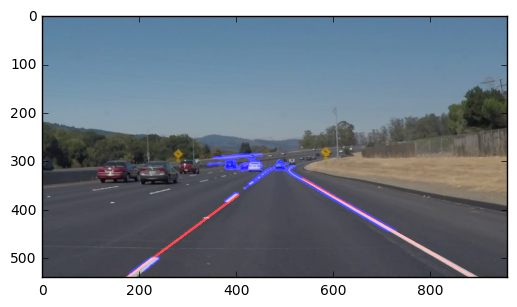

In [48]:
challenge_output = 'extra.mp4'
#clip2 = VideoFileClip('challenge.mp4').set_duration(4.5,change_end=True)
clip2 = VideoFileClip('solidWhiteRight.mp4')
#clip2 = VideoFileClip('challenge.mp4').cutout(0,3.5)
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)